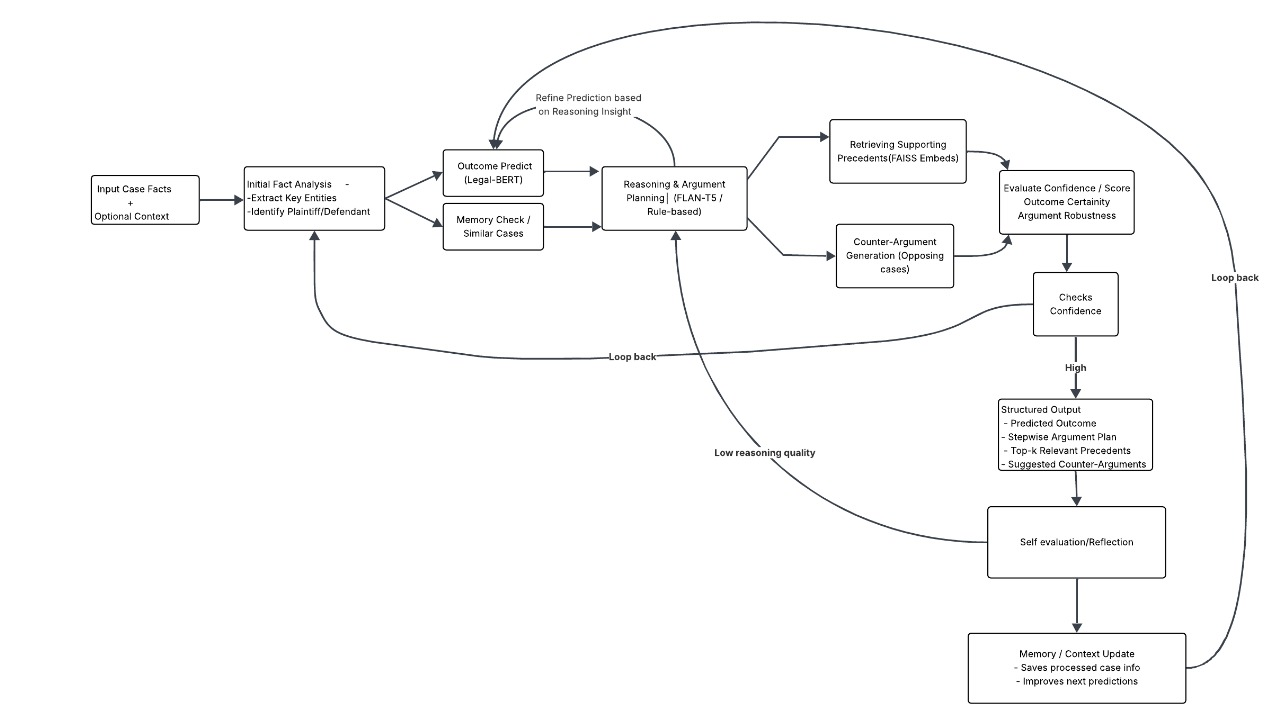

goal manager+context manager+evaluator+guard rail+continuos learn integration

In [2]:
!fusermount -u /content/drive 2>/dev/null || true
!rm -rf /content/drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [3]:
!pip install -q sentence-transformers tqdm

In [4]:
import json, os, pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [5]:

BASE = "/content/drive/MyDrive/Argumate/data"
train_path = os.path.join(BASE, "train.jsonl")
dev_path   = os.path.join(BASE, "dev.jsonl")
test_path  = os.path.join(BASE, "test.jsonl")

In [6]:

def load_jsonl(path):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return pd.DataFrame(data)

In [7]:
print("Loading datasets (this may take a few seconds)...")
train_df = load_jsonl(train_path)
dev_df   = load_jsonl(dev_path)
test_df  = load_jsonl(test_path)


print("Raw shapes ->", "train:", train_df.shape, "dev:", dev_df.shape, "test:", test_df.shape)
print("Columns (train):", train_df.columns.tolist()[:50])

Loading datasets (this may take a few seconds)...
Raw shapes -> train: (7100, 17) dev: (1380, 17) test: (2998, 17)
Columns (train): ['itemid', 'languageisocode', 'respondent', 'branch', 'date', 'docname', 'importance', 'conclusion', 'judges', 'text', 'violated_articles', 'violated_paragraphs', 'violated_bulletpoints', 'non_violated_articles', 'non_violated_paragraphs', 'non_violated_bulletpoints', 'violated']


In [8]:
checkpoint_dir = "/content/drive/MyDrive/Argumate/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
train_df.to_pickle(os.path.join(checkpoint_dir, "train_raw.pkl"))
dev_df.to_pickle(os.path.join(checkpoint_dir, "dev_raw.pkl"))
test_df.to_pickle(os.path.join(checkpoint_dir, "test_raw.pkl"))
print("Saved raw checkpoints to", checkpoint_dir)

Saved raw checkpoints to /content/drive/MyDrive/Argumate/checkpoints


In [9]:
relevant_cols = ['itemid', 'text', 'conclusion', 'violated_articles']
for df,name in [(train_df,'train'), (dev_df,'dev'), (test_df,'test')]:
    missing = [c for c in relevant_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {name}: {missing}")

In [10]:

train_df_clean = train_df[relevant_cols].copy()
dev_df_clean   = dev_df[relevant_cols].copy()
test_df_clean  = test_df[relevant_cols].copy()

In [11]:

train_df_clean.dropna(subset=['text','conclusion'], inplace=True)
dev_df_clean.dropna(subset=['text','conclusion'], inplace=True)
test_df_clean.dropna(subset=['text','conclusion'], inplace=True)

In [12]:

for df in (train_df_clean, dev_df_clean, test_df_clean):
    df['text'] = df['text'].astype(object)
    df['conclusion'] = df['conclusion'].astype(str)

    df['violated_articles'] = df['violated_articles'].astype(str)


In [13]:
def flatten_text(x):
    if isinstance(x, list):
        try:
            return " ".join([t for t in x if isinstance(t, str)])
        except:
            return str(x)
    return str(x)

for df in (train_df_clean, dev_df_clean, test_df_clean):
    df['text_clean'] = df['text'].progress_apply(flatten_text)

100%|██████████| 2998/2998 [00:00<00:00, 32533.75it/s]


In [14]:
train_df_clean.to_pickle(os.path.join(checkpoint_dir, "train_clean.pkl"))
dev_df_clean.to_pickle(os.path.join(checkpoint_dir, "dev_clean.pkl"))
test_df_clean.to_pickle(os.path.join(checkpoint_dir, "test_clean.pkl"))
print("Saved cleaned checkpoints to", checkpoint_dir)


Saved cleaned checkpoints to /content/drive/MyDrive/Argumate/checkpoints


In [15]:


print("\nTrain (clean) sample rows:", train_df_clean.shape)
display(train_df_clean[['itemid','conclusion','violated_articles','text_clean']].head(2))


num_train = len(train_df_clean)
num_dev = len(dev_df_clean)
num_test = len(test_df_clean)
num_with_violation_flag = train_df['violated'].sum() if 'violated' in train_df.columns else 'N/A'
print(f"\nSummary: train={num_train}, dev={num_dev}, test={num_test}, train 'violated' column sum: {num_with_violation_flag}")



Train (clean) sample rows: (7100, 5)


,itemid,conclusion,violated_articles,text_clean
0,001-60714,Violation of Art. 6-1;Non-pecuniary damage - f...,['6'],The applicant was born in 1943 and lives in La...
1,001-100920,Inadmissible,[],"The applicant, Mr Panayiotis Panayi, is a Cypr..."



Summary: train=7100, dev=1380, test=2998, train 'violated' column sum: 3551


entity extraction (plaintiff, defendant) and key articles extraction

In [16]:


!pip install -q huggingface-hub transformers

import re, os, torch
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
from transformers import pipeline


checkpoint_dir = "/content/drive/MyDrive/Argumate/checkpoints"
train_path_ckpt = os.path.join(checkpoint_dir, "train_clean.pkl")
dev_path_ckpt   = os.path.join(checkpoint_dir, "dev_clean.pkl")
test_path_ckpt  = os.path.join(checkpoint_dir, "test_clean.pkl")

if os.path.exists(train_path_ckpt):
    train_df_clean = pd.read_pickle(train_path_ckpt)
    dev_df_clean   = pd.read_pickle(dev_path_ckpt)
    test_df_clean  = pd.read_pickle(test_path_ckpt)
    print(" Loaded cleaned checkpoints.")
else:
    raise FileNotFoundError("Cleaned checkpoint not found. Please run data preparation cell first.")



class FactAnalysisAgent:
    """
    Agentic entity that performs:
    - Named entity extraction for plaintiff/defendant
    - Article number extraction
    - Optional LLM reasoning to validate/refine results
    """

    def __init__(self, use_llm=True):
        self.use_llm = use_llm
        if use_llm:
            try:
                self.llm = pipeline("text-generation", model="tiiuae/falcon-7b-instruct", trust_remote_code=True, device_map="auto")
                print(" LLM (Falcon-7B-Instruct) loaded for reasoning fallback.")
            except Exception as e:
                print(" Could not load Falcon LLM (likely out of VRAM or offline). Proceeding without it.")
                self.use_llm = False
                self.llm = None

    def extract_plaintiff(self, text):
        if not isinstance(text, str) or not text.strip():
            return "Unknown"
        m = re.search(r"(?:the\s+)?applicant[,:]?\s*(?:Mr\.?|Ms\.?|Mrs\.?)\s*([A-Z][A-Za-z\-\']+(?:\s+[A-Z][A-Za-z\-\']+)*)", text, flags=re.IGNORECASE)
        if m: return m.group(1).strip()
        m2 = re.search(r"(?:Mr|Ms|Mrs)\.?\s+([A-Z][A-Za-z\-\']+(?:\s+[A-Z][A-Za-z\-\']+)*)", text)
        if m2: return m2.group(1).strip()
        if "applicant" in text.lower(): return "The Applicant"
        return "Unknown"

    def extract_defendant(self, text):
        if not isinstance(text, str) or not text.strip():
            return "The Respondent"
        m = re.search(r"\b[vV]\.\s*([A-Z][A-Za-z\-\&\s]+?)[,;\.\n]", text)
        if m: return m.group(1).strip()
        if re.search(r"respondent", text, flags=re.IGNORECASE):
            m2 = re.search(r"respondent[,:\s]*([A-Z][A-Za-z\-\']+)", text, flags=re.IGNORECASE)
            if m2: return m2.group(1).strip()
            return "The Respondent"
        return "The Respondent"

    def extract_key_articles(self, text, violated_articles_field):
        articles = set()
        if isinstance(text, str):
            for m in re.findall(r"(?:Art(?:icle)?\.?\s*|article\s*)(\d+[A-Za-z\-\d]*)", text, flags=re.IGNORECASE):
                articles.add(str(m))
        if isinstance(violated_articles_field, str) and violated_articles_field.strip():
            for m in re.findall(r"\d+", violated_articles_field):
                articles.add(m)
        return sorted(list(articles), key=lambda x: str(x))


    def reason_with_llm(self, text, plaintiff, defendant, articles):
        """Use LLM to validate or refine the extracted entities."""
        if not self.use_llm or self.llm is None:
            return {"plaintiff": plaintiff, "defendant": defendant, "key_articles": articles}

        prompt = f"""
        You are a legal text analysis AI.
        Extract and confirm key entities from this case text.
        Text: {text[:400]}
        Extracted so far:
        - Plaintiff: {plaintiff}
        - Defendant: {defendant}
        - Articles: {articles}

        If the extraction seems incorrect or incomplete, refine it.
        Respond in strict JSON with keys: plaintiff, defendant, key_articles.
        """
        try:
            result = self.llm(prompt, max_new_tokens=100)[0]['generated_text']
            match = re.search(r"\{.*\}", result, re.DOTALL)
            if match:
                import json
                data = json.loads(match.group())
                return {
                    "plaintiff": data.get("plaintiff", plaintiff),
                    "defendant": data.get("defendant", defendant),
                    "key_articles": data.get("key_articles", articles),
                }
        except Exception as e:
            print(" LLM reasoning fallback failed:", e)
        return {"plaintiff": plaintiff, "defendant": defendant, "key_articles": articles}


    def analyze(self, df, name="dataset"):
        print(f"\n Running FactAnalysisAgent on {name} ({len(df)} rows)...")
        results = []
        for _, row in tqdm(df.iterrows(), total=len(df)):
            text = row.get("text_clean", "")
            viol = row.get("violated_articles", "")
            p = self.extract_plaintiff(text)
            d = self.extract_defendant(text)
            a = self.extract_key_articles(text, viol)
            refined = self.reason_with_llm(text, p, d, a)
            results.append(refined)
        df["plaintiff"] = [r["plaintiff"] for r in results]
        df["defendant"] = [r["defendant"] for r in results]
        df["key_articles"] = [r["key_articles"] for r in results]
        df.to_pickle(os.path.join(checkpoint_dir, f"{name}_stage_entities_agent.pkl"))
        print(f" Saved {name}_stage_entities_agent.pkl")
        return df


fact_agent = FactAnalysisAgent(use_llm=True)
print(" FactAnalysisAgent initialized successfully.")


 Loaded cleaned checkpoints.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu


 LLM (Falcon-7B-Instruct) loaded for reasoning fallback.
 FactAnalysisAgent initialized successfully.


In [17]:


sample_text = dev_df_clean.iloc[1]["text_clean"]
print("\n Sample Text (first 400 chars):\n", sample_text[:400], "...")

result = fact_agent.reason_with_llm(
    sample_text,
    fact_agent.extract_plaintiff(sample_text),
    fact_agent.extract_defendant(sample_text),
    fact_agent.extract_key_articles(sample_text, dev_df_clean.iloc[0]["violated_articles"])
)

print("\n Agent Output:")
print(result)


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



 Sample Text (first 400 chars):
 The applicant, Mr John James Shannon, is a United Kingdom national, who was born in 1971 and lives in London. He is represented before the Court by Mr Andrew Parker, a lawyer practising in London. The facts of the case, as submitted by the parties, may be summarised as follows. The applicant is an actor and at the relevant time starred in “London's Burning”, a popular British drama series. In or a ...
 LLM reasoning fallback failed: 'NoneType' object has no attribute 'shape'

 Agent Output:
{'plaintiff': 'John James Shannon', 'defendant': 'Loosely', 'key_articles': ['13', '3', '6']}


Batch Legal-BERT prediction

In [18]:
import pandas as pd

train_df = pd.read_json("/content/drive/MyDrive/Argumate/data/train.jsonl", lines=True)
dev_df   = pd.read_json("/content/drive/MyDrive/Argumate/data/dev.jsonl", lines=True)


train_texts = train_df["text"]
train_labels = train_df["violated"].astype(int)

dev_texts = dev_df["text"]
dev_labels = dev_df["violated"].astype(int)


In [19]:
!pip install -q transformers datasets tqdm accelerate

In [ ]:
import pandas as pd
import torch
from tqdm.auto import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support


print(" Loading dataset...")

train_path = "/content/drive/MyDrive/Argumate/data/train.jsonl"
dev_path   = "/content/drive/MyDrive/Argumate/data/dev.jsonl"

train_df = pd.read_json(train_path, lines=True)
dev_df   = pd.read_json(dev_path, lines=True)


train_df["text"] = train_df["text"].astype(str)
dev_df["text"]   = dev_df["text"].astype(str)
train_df["violated"] = train_df["violated"].astype(int)
dev_df["violated"]   = dev_df["violated"].astype(int)

print(f" Train samples: {len(train_df)} | Dev samples: {len(dev_df)}")


print("\n Tokenizing text...")

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-small-uncased")

def tokenize_data(texts):

    all_encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="pt"
    )
    return all_encodings

train_encodings = tokenize_data(train_df["text"].tolist())
dev_encodings   = tokenize_data(dev_df["text"].tolist())


class ECHRDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ECHRDataset(train_encodings, train_df["violated"].tolist())
dev_dataset   = ECHRDataset(dev_encodings, dev_df["violated"].tolist())


print("\n Initializing model...")

model = AutoModelForSequenceClassification.from_pretrained(
    "nlpaueb/legal-bert-small-uncased",
    num_labels=2
)

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Argumate/checkpoints/legalbert_cpu_finetune",
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none"
)


def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average="binary")
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


print("\n Training started (CPU mode)...")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


print("\n Evaluating model...")
results = trainer.evaluate()
print(" Evaluation:", results)


print("\n Checking predictions vs true labels...")

preds = trainer.predict(dev_dataset)
pred_labels = preds.predictions.argmax(-1)
true_labels = dev_df["violated"].tolist()

print(classification_report(true_labels, pred_labels, target_names=["Non-Violation", "Violation"]))


for i in range(2):
    print(f"\n Case {i+1}")
    print("Text:", dev_df.iloc[i]["text"][:200].replace("\n", " "), "...")
    print("True Label:", "Violation" if true_labels[i]==1 else "Non-Violation")
    print("Predicted Label:", "Violation" if pred_labels[i]==1 else "Non-Violation")



save_path = "/content/drive/MyDrive/Argumate/checkpoints/legalbert_cpu_finetune/final_checkpoint"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\n Fine-tuned model + tokenizer saved at: {save_path}")

print("\n All steps complete! Model trained, evaluated, and checkpoint saved.")


Step 4 – Outcome Predictor agent

In [20]:

import torch, json, re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

class OutcomePredictorAgent:
    def __init__(self, model_path="/content/drive/MyDrive/Argumate/checkpoints/legalbert_cpu_finetune/final_checkpoint"):
        self.model_path = model_path
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
        self.label_map = {0: "Non-Violation", 1: "Violation"}
        try:
            self.llm = pipeline("text-generation", model="distilgpt2", device_map="auto")
            print(" Lightweight reasoning LLM (distilgpt2) loaded.")
        except Exception:
            self.llm = None
            print(" LLM unavailable, using LegalBERT only.")
        self.model.eval()

    def predict(self, text):
        if isinstance(text, list):
            text = " ".join(map(str, text))
        if not isinstance(text, str):
            text = str(text)
        text = text.strip()
        if not text:
            return {"outcome": "Unknown"}


        inputs = self.tokenizer([text], return_tensors="pt",
                                truncation=True, padding=True, max_length=256).to(device)
        with torch.no_grad():
            logits = self.model(**inputs).logits
            label = int(torch.argmax(logits, dim=-1)[0].cpu().numpy())

        result = {"outcome": self.label_map[label]}


        if self.llm:
            prompt = (f"LegalBERT predicts '{result['outcome']}'. "
                      f"Confirm or adjust if the case context implies otherwise.\n"
                      f"Text: {text[:400]}\n"
                      "Respond strictly as JSON: {'outcome': '...'}")
            try:
                gen = self.llm(prompt, max_new_tokens=50, pad_token_id=50256)[0]['generated_text']
                match = re.search(r"\{.*\}", gen)
                if match:
                    data = json.loads(match.group())
                    result.update(data)
            except Exception:
                pass
        return result

    def save_checkpoint(self, save_path="/content/drive/MyDrive/Argumate/checkpoints/outcome_predictor_agent"):
        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)
        print(f" Predictor agent model saved at: {save_path}")

predictor_agent = OutcomePredictorAgent()
predictor_agent.save_checkpoint()
print(" OutcomePredictorAgent ready (no confidence).")


Device set to use cpu


 Lightweight reasoning LLM (distilgpt2) loaded.
 Predictor agent model saved at: /content/drive/MyDrive/Argumate/checkpoints/outcome_predictor_agent
 OutcomePredictorAgent ready (no confidence).


Step 5- Memory retrieval agent

In [21]:
!pip install -q sentence-transformers faiss-cpu huggingface-hub transformers

In [22]:

import numpy as np, faiss, re, json, pickle
from sentence_transformers import SentenceTransformer
from transformers import pipeline

class MemoryRetrievalAgent:
    def __init__(self, embedder="sentence-transformers/paraphrase-MiniLM-L6-v2", use_reasoning=True):
        self.embedder_name = embedder
        self.model = SentenceTransformer(embedder)
        self.index = None
        self.corpus = []
        self.use_reasoning = use_reasoning
        if use_reasoning:
            try:
                self.llm = pipeline("text-generation", model="distilgpt2", device_map="auto")
                print(" distilgpt2 loaded for retrieval summaries.")
            except Exception:
                self.llm = None
        else:
            self.llm = None

    def build_memory(self, texts):
        print(f"Building FAISS index for {len(texts)} cases…")
        self.corpus = texts
        emb = self.model.encode(texts, convert_to_numpy=True, show_progress_bar=True)
        dim = emb.shape[1]
        self.index = faiss.IndexFlatL2(dim)
        self.index.add(emb.astype("float32"))
        print(" FAISS index built.")

    def retrieve(self, query, k=3):
        if self.index is None:
            raise ValueError("Index not built.")
        q = self.model.encode([query], convert_to_numpy=True)
        D, I = self.index.search(q.astype("float32"), k)
        results = [self.corpus[i] for i in I[0]]
        if self.llm:
            try:
                short_texts = " | ".join([r[:150].replace("\n", " ") for r in results])
                prompt = (f"Given these precedent snippets: {short_texts}. "
                          "Summarize in one short sentence their shared theme.")
                summary = self.llm(prompt, max_new_tokens=50, pad_token_id=50256)[0]['generated_text']
                print("Retrieval summary:", summary[:200], "\n")
            except Exception:
                pass
        return results

    def save_checkpoint(self, path="/content/drive/MyDrive/Argumate/checkpoints/memory_agent.pkl"):
        data = {
            "embedder": self.embedder_name,
            "corpus": self.corpus
        }
        with open(path, "wb") as f:
            pickle.dump(data, f)
        print(f" Memory agent checkpoint saved at: {path}")


subset_texts = pd.read_pickle("/content/drive/MyDrive/Argumate/checkpoints/train_clean.pkl")["text_clean"].head(500).tolist()
memory_agent = MemoryRetrievalAgent()
memory_agent.build_memory(subset_texts)
memory_agent.save_checkpoint()
print(" MemoryRetrievalAgent ready & saved.")


Device set to use cpu


 distilgpt2 loaded for retrieval summaries.
Building FAISS index for 500 cases…


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

 FAISS index built.
 Memory agent checkpoint saved at: /content/drive/MyDrive/Argumate/checkpoints/memory_agent.pkl
 MemoryRetrievalAgent ready & saved.


Combined Function (Parallel Agent Stage)

In [23]:

import json, re
from transformers import pipeline
from IPython.display import display, Markdown

class CaseAnalysisAgent:
    def __init__(self, predictor, memory, model_name="distilgpt2"):
        self.predictor = predictor
        self.memory = memory
        try:
            self.llm = pipeline("text-generation", model=model_name, device_map="auto")
            print(f" Reasoning model '{model_name}' loaded for fusion.")
        except Exception as e:
            print(" LLM unavailable:", e)
            self.llm = None

    def analyze(self, text):
        print("\n=== CASE ANALYSIS START ===")
        pred = self.predictor.predict(text)
        precedents = self.memory.retrieve(text, k=3)

        output = {
            "Predicted_Outcome": pred.get("outcome", "Unknown"),
            "Final_Outcome": pred.get("outcome", "Unknown"),
            "Rationale": "No reasoning available.",
            "Similar_Precedents": [p[:200].replace("\n", " ") for p in precedents]
        }

        if self.llm:
            prompt = (
                f"Outcome predicted: {pred.get('outcome', 'Unknown')}. "
                f"Similar precedents: {output['Similar_Precedents']}.\n"
                "Provide final decision and short rationale as JSON: "
                "{'Final_Outcome':..., 'Rationale':...}"
            )
            prompt = prompt[:500]
            try:
                gen = self.llm(prompt, max_new_tokens=80, pad_token_id=50256)[0]["generated_text"]
                print("\n Raw LLM output (for debugging):", gen[:300], "\n")
                match = re.search(r"\{.*\}", gen)
                if match:
                    data = json.loads(match.group())

                    output["Final_Outcome"] = data.get("Final_Outcome", output["Final_Outcome"])
                    output["Rationale"] = data.get("Rationale", output["Rationale"])
            except Exception as e:
                print(" Generation or JSON parsing failed:", e)
                output["Rationale"] = "Fallback reasoning (JSON parse failed)."
        else:
            output["Rationale"] = "Fallback reasoning (no reasoning model)."


        print("\n###  Structured Case Summary ###")
        md = f"""
        **Predicted Outcome:** {output['Predicted_Outcome']}
        **Final Outcome:** {output['Final_Outcome']}
        **Rationale:** {output['Rationale']}

        **Top Precedents:**
        """
        for i, p in enumerate(output["Similar_Precedents"], 1):
            md += f"- {i}. {p[:150]}...\n"
        display(Markdown(md))

        return output


combined_agent = CaseAnalysisAgent(predictor_agent, memory_agent)
print("Combined Agent (KeyError-proof) ready.")


Device set to use cpu


 Reasoning model 'distilgpt2' loaded for fusion.
Combined Agent (KeyError-proof) ready.


In [24]:
sample_df = pd.read_json("/content/drive/MyDrive/Argumate/data/dev.jsonl", lines=True)
test_text = sample_df.iloc[0]["text"]

print("\nRunning Combined Agent...\n")
result = combined_agent.analyze(test_text)

print(" Final Structured Output:\n")
print(json.dumps(result, indent=2))



Running Combined Agent...


=== CASE ANALYSIS START ===
Retrieval summary: Given these precedent snippets: The applicant, Mr Nikolay Vasilyevich Samoylovich, is a Ukrainian national who was born in 1969 and lives in Simferopol. On 29 January 1997 the Kyiv d | On 19 November  


 Raw LLM output (for debugging): Outcome predicted: Violation. Similar precedents: ['The applicant, Mr Nikolay Vasilyevich Samoylovich, is a Ukrainian national who was born in 1969 and lives in Simferopol. On 29 January 1997 the Kyiv district prosecutor’s office at Simferopol opened c', 'On 19 November 1996 the applicant was arrest 


###  Structured Case Summary ###



        **Predicted Outcome:** Violation
        **Final Outcome:** Violation
        **Rationale:** No reasoning available.

        **Top Precedents:**
        - 1. The applicant, Mr Nikolay Vasilyevich Samoylovich, is a Ukrainian national who was born in 1969 and lives in Simferopol. On 29 January 1997 the Kyiv d...
- 2. On 19 November 1996 the applicant was arrested and detained on suspicion of committing an offence. On 22 November 1996 he was charged with seven count...
- 3. The applicant was born in 1977 and lives in Budapest. On 26 February 2002 criminal proceedings were instituted against the applicant, a college studen...


 Final Structured Output:

{
  "Predicted_Outcome": "Violation",
  "Final_Outcome": "Violation",
  "Rationale": "No reasoning available.",
  "Similar_Precedents": [
    "The applicant, Mr Nikolay Vasilyevich Samoylovich, is a Ukrainian national who was born in 1969 and lives in Simferopol. On 29 January 1997 the Kyiv district prosecutor\u2019s office at Simferopol opened c",
    "On 19 November 1996 the applicant was arrested and detained on suspicion of committing an offence. On 22 November 1996 he was charged with seven counts of theft, one count of attempted theft and one c",
    "The applicant was born in 1977 and lives in Budapest. On 26 February 2002 criminal proceedings were instituted against the applicant, a college student, on a charge of extortion, which had allegedly b"
  ]
}


Reasoning & Argument Planning Agent (FLAN-T5)

In [25]:

import os, json, re
import torch
from difflib import SequenceMatcher
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device for reasoning:", device)

class ReasoningPlanningAgent:
    def __init__(self,
                 model_name="google/flan-t5-small",
                 predictor_agent=None,
                 save_path="/content/drive/MyDrive/Argumate/checkpoints/reasoning_agent"):
        self.model_name = model_name
        self.device = device
        self.predictor_agent = predictor_agent
        self.save_path = save_path

        print(f"Loading reasoning model: {model_name} …")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(self.device)
        self.model.eval()
        print(" ReasoningPlanningAgent loaded and ready.")


    def _to_str(self, text):
        """Ensure text is always a string."""
        if isinstance(text, list):
            text = " ".join(map(str, text))
        elif not isinstance(text, str):
            text = str(text)
        return text.strip()

    def _similarity(self, a, b):
        """Robust similarity that auto-converts types."""
        a = self._to_str(a)
        b = self._to_str(b)
        return SequenceMatcher(None, a.lower(), b.lower()).ratio()

    def _fallback_reasoning(self, text, outcome, precedents):
        """Rule-based fallback reasoning."""
        text = self._to_str(text)
        sentences = re.split(r'(?<=[.!?])\s+', text.strip())
        facts = " ".join(sentences[:3])
        issue = "Whether the described acts constitute a breach of the Convention."
        if precedents:
            prec = " | ".join([self._to_str(p)[:120].replace("\n"," ") for p in precedents[:2]])
            analysis = f"Facts are compared to precedents ({prec}); the similarity indicates same pattern of violation."
        else:
            analysis = "No direct precedent; reasoning based on general legal principles."
        conclusion = f"Thus, reasoning supports '{outcome}'."
        return {
            "issue": issue,
            "facts_summary": facts,
            "analysis": analysis,
            "conclusion": conclusion,
            "used_model": "rule-based"
        }


    def generate_reasoning(self, case_text, predicted_outcome, precedents):
        """Generate structured reasoning safely."""
        case_text = self._to_str(case_text)
        precedents = [self._to_str(p) for p in (precedents or [])]

        prompt = f"""
You are a senior legal reasoning agent assisting the European Court of Human Rights.
Generate a **structured reasoning** in this exact format:

ISSUE:
FACTS SUMMARY:
LEGAL ANALYSIS:
CONCLUSION:

Use concise, professional legal phrasing (8–12 sentences total).
Avoid repeating the case text verbatim.

Case Summary:
{case_text[:900]}

Predicted Outcome: {predicted_outcome}
Relevant Precedents:
{chr(10).join(precedents[:3]) if precedents else "None"}
"""
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=1024).to(self.device)
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_length=320,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=3,
                repetition_penalty=1.2,
            )
        gen_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True).strip()


        if self._similarity(gen_text, case_text[:600]) > 0.45 or len(gen_text) < 80:
            print(" Reasoning.")
            return self._fallback_reasoning(case_text, predicted_outcome, precedents)

        def extract(label):
            m = re.search(rf"{label}\s*:\s*(.*?)(?=\n[A-Z ]+?:|\Z)", gen_text, flags=re.DOTALL | re.IGNORECASE)
            return m.group(1).strip() if m else ""

        issue = extract("ISSUE")
        facts = extract("FACTS SUMMARY") or extract("FACTS")
        analysis = extract("LEGAL ANALYSIS") or extract("ANALYSIS")
        conclusion = extract("CONCLUSION") or extract("RESULT")

        if not (issue and facts and analysis and conclusion):
            fallback = self._fallback_reasoning(case_text, predicted_outcome, precedents)
            issue = issue or fallback["issue"]
            facts = facts or fallback["facts_summary"]
            analysis = analysis or fallback["analysis"]
            conclusion = conclusion or fallback["conclusion"]
            used = "flan-t5 + fallback"
        else:
            used = "flan-t5"

        reasoning = {
            "issue": issue,
            "facts_summary": facts,
            "analysis": analysis,
            "conclusion": conclusion,
            "used_model": used,
            "raw_output": gen_text
        }
        return reasoning

    def self_review_loop(self, case_text, precedents, max_loops=2):
        case_text = self._to_str(case_text)
        precedents = [self._to_str(p) for p in (precedents or [])]
        outcome = "Violation"
        history = []
        for i in range(max_loops):
            print(f"\n Loop iteration {i+1}")
            reasoning = self.generate_reasoning(case_text, outcome, precedents)
            history.append(reasoning)
            if not self.predictor_agent:
                print("No predictor linked — loop ends.")
                break
            check_text = reasoning["facts_summary"] + " " + reasoning["analysis"]
            pred_check = self.predictor_agent.predict(check_text)
            new_outcome = pred_check.get("outcome", outcome)
            print(f"Predicted again by OutcomeAgent: {new_outcome}")
            if new_outcome == outcome:
                print(" Consistent outcome reached.")
                break
            else:
                print(f" Adjusting outcome: {outcome} → {new_outcome}")
                outcome = new_outcome
        return {"final_outcome": outcome, "reasoning_history": history}


    def save_agent(self):
        os.makedirs(self.save_path, exist_ok=True)
        self.model.save_pretrained(self.save_path)
        self.tokenizer.save_pretrained(self.save_path)
        print(f" Reasoning agent saved to {self.save_path}")


reasoning_agent = ReasoningPlanningAgent(predictor_agent=predictor_agent)
reasoning_agent.save_agent()
print(" ReasoningPlanningAgent (type-safe) initialized & saved.")


Device for reasoning: cpu
Loading reasoning model: google/flan-t5-small …
 ReasoningPlanningAgent loaded and ready.
 Reasoning agent saved to /content/drive/MyDrive/Argumate/checkpoints/reasoning_agent
 ReasoningPlanningAgent (type-safe) initialized & saved.


In [26]:
print("\nRunning Combined Agent first...\n")
combined_result = combined_agent.analyze(test_text)

print("\nRunning Reasoning Agent...\n")
reasoning_result = reasoning_agent.generate_reasoning(
    case_text=test_text,
    predicted_outcome=combined_result["Final_Outcome"],
    precedents=combined_result["Similar_Precedents"]
)

from IPython.display import display, Markdown
md = f"""
###  Generated Legal Reasoning
**Issue:** {reasoning_result['issue']}
**Facts Summary:** {reasoning_result['facts_summary']}
**Legal Analysis:** {reasoning_result['analysis']}
**Conclusion:** {reasoning_result['conclusion']}
**Model Used:** {reasoning_result['used_model']}
"""
display(Markdown(md))



Running Combined Agent first...


=== CASE ANALYSIS START ===
Retrieval summary: Given these precedent snippets: The applicant, Mr Nikolay Vasilyevich Samoylovich, is a Ukrainian national who was born in 1969 and lives in Simferopol. On 29 January 1997 the Kyiv d | On 19 November  


 Raw LLM output (for debugging): Outcome predicted: Violation. Similar precedents: ['The applicant, Mr Nikolay Vasilyevich Samoylovich, is a Ukrainian national who was born in 1969 and lives in Simferopol. On 29 January 1997 the Kyiv district prosecutor’s office at Simferopol opened c', 'On 19 November 1996 the applicant was arrest 


###  Structured Case Summary ###



        **Predicted Outcome:** Violation
        **Final Outcome:** Violation
        **Rationale:** No reasoning available.

        **Top Precedents:**
        - 1. The applicant, Mr Nikolay Vasilyevich Samoylovich, is a Ukrainian national who was born in 1969 and lives in Simferopol. On 29 January 1997 the Kyiv d...
- 2. On 19 November 1996 the applicant was arrested and detained on suspicion of committing an offence. On 22 November 1996 he was charged with seven count...
- 3. The applicant was born in 1977 and lives in Budapest. On 26 February 2002 criminal proceedings were instituted against the applicant, a college studen...



Running Reasoning Agent...




###  Generated Legal Reasoning
**Issue:** Whether the described acts constitute a breach of the Convention.
**Facts Summary:** The applicant was born in 1947 and lives in Simferopol. On 19 June 1999 the applicant was arrested on suspicion of theft and abuse of power. On 23 June 1999 the applicant was placed in the Simferopol Temporary Detention Centre No.
**Legal Analysis:** Facts are compared to precedents (The applicant, Mr Nikolay Vasilyevich Samoylovich, is a Ukrainian national who was born in 1969 and lives in Simferopol. | On 19 November 1996 the applicant was arrested and detained on suspicion of committing an offence. On 22 November 1996 h); the similarity indicates same pattern of violation.
**Conclusion:** Thus, reasoning supports 'Violation'.
**Model Used:** flan-t5 + fallback


STAGE 4: Supporting Precedent Retrieval Agent

In [27]:

import os, json, faiss, numpy as np, re
from sentence_transformers import SentenceTransformer
from transformers import pipeline

class SupportingPrecedentsAgent:
    def __init__(self,
                 memory_checkpoint="/content/drive/MyDrive/Argumate/checkpoints/train_clean.pkl",
                 embedder="sentence-transformers/paraphrase-MiniLM-L6-v2",
                 reasoning_model="google/flan-t5-small"):
        print("Initializing SupportingPrecedentsAgent...")
        self.embedder = SentenceTransformer(embedder)
        self.llm = pipeline("text2text-generation", model=reasoning_model, device_map="auto")
        self.memory_checkpoint = memory_checkpoint
        self.index = None
        self.corpus = []
        print(" Model and reasoning LLM loaded.")

    def build_index(self, top_n=1000):
        """Rebuild FAISS index from existing checkpoint (subset for speed)."""
        import pandas as pd
        df = pd.read_pickle(self.memory_checkpoint)
        self.corpus = df["text_clean"].head(top_n).tolist()
        print(f"Building FAISS index for {len(self.corpus)} cases...")
        embeds = self.embedder.encode(self.corpus, convert_to_numpy=True, show_progress_bar=True)
        dim = embeds.shape[1]
        self.index = faiss.IndexFlatL2(dim)
        self.index.add(embeds.astype("float32"))
        print(" FAISS index ready for retrieval.")

    def retrieve_supporting(self, query_text, predicted_outcome="Violation", k=3):
        """Retrieve top-k supporting precedents using FAISS + reasoning filter."""
        if self.index is None:
            raise ValueError("FAISS index not built yet. Run build_index() first.")

        query_emb = self.embedder.encode([query_text], convert_to_numpy=True)
        D, I = self.index.search(query_emb.astype("float32"), k)
        retrieved = [self.corpus[i] for i in I[0]]

        print(f"\n Retrieved {len(retrieved)} candidate precedents.")

        precedents_text = " | ".join([r[:180].replace("\n"," ") for r in retrieved])
        prompt = f"""
You are a legal assistant summarizing precedents that **support** a predicted outcome of "{predicted_outcome}".
Given these precedent excerpts, briefly summarize their key supportive reasoning in 2-3 sentences.

Precedents:
{precedents_text}
"""
        summary = self.llm(prompt, max_new_tokens=100)[0]["generated_text"]
        return {
            "supporting_precedents": retrieved,
            "summary": summary.strip(),
            "predicted_outcome": predicted_outcome
        }

    def save_agent(self, save_path="/content/drive/MyDrive/Argumate/checkpoints/supporting_precedents_agent"):
        os.makedirs(save_path, exist_ok=True)
        self.embedder.save(os.path.join(save_path, "embedder"))
        print(f" SupportingPrecedentsAgent checkpoint saved at {save_path}")


supporting_agent = SupportingPrecedentsAgent()
supporting_agent.build_index()
supporting_agent.save_agent()
print(" SupportingPrecedentsAgent initialized & saved.")


Initializing SupportingPrecedentsAgent...


Device set to use cpu


 Model and reasoning LLM loaded.
Building FAISS index for 1000 cases...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

 FAISS index ready for retrieval.
 SupportingPrecedentsAgent checkpoint saved at /content/drive/MyDrive/Argumate/checkpoints/supporting_precedents_agent
 SupportingPrecedentsAgent initialized & saved.


In [28]:

test_case_text = """
The applicant was detained for over a year without judicial review or access to counsel,
alleging violation of Article 5 and 6 of the European Convention on Human Rights.
"""

print("\nRunning Supporting Precedents Agent...\n")
support_result = supporting_agent.retrieve_supporting(
    query_text=test_case_text,
    predicted_outcome="Violation"
)

print("\n###  Supporting Precedents Summary ###")
print("Predicted Outcome:", support_result["predicted_outcome"])
print("LLM Summary:", support_result["summary"])
print("\nTop Retrieved Precedents:")
for i, p in enumerate(support_result["supporting_precedents"], 1):
    print(f"{i}. {p[:200]}...")



Running Supporting Precedents Agent...


 Retrieved 3 candidate precedents.

###  Supporting Precedents Summary ###
Predicted Outcome: Violation
LLM Summary: On 12 | The applicant, a Belgian national born in 1964, was arrested on suspicion of violent robbery and unlawful possession of weapons. On 12 | The applicant, a Belgian national born in 1964, was arrested on suspicion of violent robbery and unlawful possession of weapons.

Top Retrieved Precedents:
1. The applicant was born in 1964 and lives in Krivoborye, Voronezh Region. On 25 July 2001 the applicant was arrested on suspicion of robbery. On 27 July 2001 the Prosecutor ordered the pre-trial detent...
2. The applicant was born in 1981 and lives in the Kharkiv Region. On 11 October 2001 the police arrested him on suspicion of violent robbery and unlawful possession of weapons. On 12 October 2001 the Va...
3. The applicant, a Belgian national born in 1964, was arrested on 14 November 1992 for an assault causing its victim to be ce

STAGE 5: Counter-Argument Generation Agent

In [29]:
!pip install -q transformers sentence-transformers

In [30]:
import os, json, re, textwrap
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


SAVE_DIR = "/content/drive/MyDrive/Argumate/checkpoints/counterarg_agent"
os.makedirs(SAVE_DIR, exist_ok=True)
MODEL_NAME = "google/flan-t5-small"
MAX_INPUT = 900
MAX_NEW_TOKENS = 200


def _to_str(x):
    if isinstance(x, list):
        return " ".join(map(str, x))
    if x is None:
        return ""
    return str(x)

class CounterArgumentAgent:
    def __init__(self, model_name=MODEL_NAME, device=None):
        self.model_name = model_name
        self.device = device if device is not None else ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.tokenizer = None
        try:
            print(f"Loading CounterArgument model '{model_name}' on {self.device} ...")
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(self.device)
            self.model.eval()
            print("CounterArgumentAgent model loaded.")
        except Exception as e:
            print("Could not load flan-t5 model (fallback to rule-based):", e)
            self.model = None
            self.tokenizer = None

    def _rule_fallback(self, case_text, precedents):

        case_text = _to_str(case_text).lower()
        pts = []

        if "detain" in case_text or "detention" in case_text:
            pts.append({
                "title": "Lawful Detention / Reasonable Grounds",
                "legal_rationale": "The respondent may argue that lawful detention was based on reasonable, articulable grounds and due process was followed in initial stages.",
                "supporting_precedents": precedents[:2],
                "weakness": "May be undermined if procedural safeguards were absent."
            })
        else:
            pts.append({
                "title": "Lack of Causal Link",
                "legal_rationale": "The respondent may assert that the alleged act does not meet the threshold for Convention breach due to lack of proximate causal link.",
                "supporting_precedents": precedents[:2],
                "weakness": "Requires factual proof which may be contested."
            })

        pts.append({
            "title": "Domestic Remedies / Exhaustion",
            "legal_rationale": "The respondent can point to available domestic remedies not exhausted by the applicant, which may render the application inadmissible.",
            "supporting_precedents": precedents[:2],
            "weakness": "If domestic remedies were ineffective, this will not hold."
        })
        pts.append({
            "title": "Proportionality & Margin of Appreciation",
            "legal_rationale": "Even if interference occurred, the respondent may argue it fell within the State's margin of appreciation and was proportionate to a legitimate aim.",
            "supporting_precedents": precedents[:2],
            "weakness": "Less persuasive where fundamental rights were at stake."
        })
        return pts[:3]

    def generate_counterarguments(self, case_text, precedents=None, num_counterpoints=3):
        precedents = [ _to_str(p) for p in (precedents or []) ]
        case_text = _to_str(case_text)[:MAX_INPUT]

        if self.model is None:
            print("Using rule-based counterargument generator (safe fallback).")
            return self._rule_fallback(case_text, precedents)


        prompt = textwrap.dedent(f"""
        You are a defending legal counsel drafting structured counter-arguments against an applicant's claim.
        Produce {num_counterpoints} numbered counterpoints. Each counterpoint must include:
        - Title
        - Legal Rationale: 3-5 sentences explaining why this limits or undermines the applicant's claim.
        - Supporting Precedents: list 1-2 short citations (if available).
        - Weakness: one short sentence.

        Case facts (short):
        {case_text}

        Top precedents (short snippets):
        {chr(10).join(precedents[:4]) if precedents else "None"}
        """).strip()

        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=1024).to(self.device)
        with torch.no_grad():
            outs = self.model.generate(
                **inputs,
                max_length=inputs["input_ids"].shape[1] + MAX_NEW_TOKENS,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=3,
                length_penalty=1.0,
                do_sample=False
            )
        gen = self.tokenizer.decode(outs[0], skip_special_tokens=True).strip()


        gen_norm = re.sub(r"[^\x00-\x7F]+", " ", gen)

        parts = re.split(r"\n\s*(?:\d+[\.\)]\s+)", gen_norm)

        pts = []
        for p in parts[1:1+num_counterpoints]:
            p = p.strip()
            if not p:
                continue

            lines = [l for l in p.split("\n") if l.strip()]
            title = lines[0][:120] if lines else "Counterpoint"
            body = " ".join(lines[1:]).strip()

            supp = []
            weak = ""

            m_supp = re.search(r"(Supporting Precedents[:\-]\s*)(.+?)(?:Weakness[:\-]|\Z)", p, flags=re.I|re.S)
            if m_supp:
                supp_text = m_supp.group(2).strip()

                supp = [s.strip() for s in re.split(r"[;,\n]", supp_text) if s.strip()][:2]
            m_weak = re.search(r"Weakness[:\-]\s*(.+)", p, flags=re.I|re.S)
            if m_weak:
                weak = m_weak.group(1).strip().split("\n")[0]
            pts.append({
                "title": title,
                "legal_rationale": body[:900],
                "supporting_precedents": supp,
                "weakness": weak
            })

        if len(pts) < num_counterpoints:
            fb = self._rule_fallback(case_text, precedents)
            return fb
        return pts

    def save_agent(self, path=SAVE_DIR):
        if self.model is not None and self.tokenizer is not None:
            self.model.save_pretrained(path)
            self.tokenizer.save_pretrained(path)
            print(f"Saved CounterArgumentAgent model to {path}")
        else:
            print("Model not available — nothing saved.")


counter_agent = CounterArgumentAgent()



Loading CounterArgument model 'google/flan-t5-small' on cpu ...
CounterArgumentAgent model loaded.


In [31]:

demo_case = """
The applicant was detained for over a year without judicial review or access to counsel,
alleging violation of Article 5 and 6 of the European Convention on Human Rights.
"""

demo_precedents = [
    "Lawless v. Ireland (1961): preventive detention during emergency justified.",
    "Brogan v. UK (1988): short-term detention without judicial review under certain conditions.",
    "Akdivar v. Turkey (1996): exhaustion of domestic remedies required before admissibility."
]

print("\n==================== RUNNING COUNTER-ARGUMENT AGENT ====================\n")
counter_output = counter_agent.generate_counterarguments(
    case_text=demo_case,
    precedents=demo_precedents,
    num_counterpoints=3
)

print("\n###  Counter-Arguments Generated ###\n")
for i, cp in enumerate(counter_output, 1):
    print(f"  Counterpoint {i}")
    print(f" Title: {cp.get('title','N/A')}")
    print(f" Legal Rationale: {cp.get('legal_rationale','N/A')[:600]}")
    print(f" Supporting Precedents: {cp.get('supporting_precedents','N/A')}")
    print(f" Weakness: {cp.get('weakness','N/A')}")
    print("-" * 90)





==================== RUNNING COUNTER-ARGUMENT AGENT ====================


###  Counter-Arguments Generated ###

  Counterpoint 1
 Title: Lawful Detention / Reasonable Grounds
 Legal Rationale: The respondent may argue that lawful detention was based on reasonable, articulable grounds and due process was followed in initial stages.
 Supporting Precedents: ['Lawless v. Ireland (1961): preventive detention during emergency justified.', 'Brogan v. UK (1988): short-term detention without judicial review under certain conditions.']
 Weakness: May be undermined if procedural safeguards were absent.
------------------------------------------------------------------------------------------
  Counterpoint 2
 Title: Domestic Remedies / Exhaustion
 Legal Rationale: The respondent can point to available domestic remedies not exhausted by the applicant, which may render the application inadmissible.
 Supporting Precedents: ['Lawless v. Ireland (1961): preventive detention during emergency justifie

confidence evaluator agent

In [32]:

predictor_agent = OutcomePredictorAgent()
reasoning_agent = ReasoningPlanningAgent(predictor_agent=predictor_agent)
supporting_agent = SupportingPrecedentsAgent()
supporting_agent.build_index()
counter_agent = CounterArgumentAgent()


Device set to use cpu


 Lightweight reasoning LLM (distilgpt2) loaded.
Loading reasoning model: google/flan-t5-small …
 ReasoningPlanningAgent loaded and ready.
Initializing SupportingPrecedentsAgent...


Device set to use cpu


 Model and reasoning LLM loaded.
Building FAISS index for 1000 cases...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

 FAISS index ready for retrieval.
Loading CounterArgument model 'google/flan-t5-small' on cpu ...
CounterArgumentAgent model loaded.


In [33]:

import os, json, numpy as np, re
from transformers import pipeline
from datetime import datetime

CONF_THRESHOLD = 0.75
MAX_LOOPS = 3
SAVE_REPORTS = True
RESULTS_DIR = "/content/drive/MyDrive/Argumate/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

class EvaluatorAgent:
    def __init__(self, predictor_agent, reasoning_agent, supporting_agent, counter_agent,
                 threshold=CONF_THRESHOLD, max_loops=MAX_LOOPS):
        self.predictor_agent = predictor_agent
        self.reasoning_agent = reasoning_agent
        self.supporting_agent = supporting_agent
        self.counter_agent = counter_agent
        self.threshold = threshold
        self.max_loops = max_loops

        try:
            self.llm = pipeline("text2text-generation", model="google/flan-t5-small", device_map="auto")
            print(" EvaluatorAgent initialized with FLAN-T5 for lightweight scoring.")
        except Exception as e:
            print(" Could not load FLAN model:", e)
            self.llm = None


    def _safe_text(self, x):
        if isinstance(x, list): return " ".join(map(str, x))
        if not isinstance(x, str): return str(x)
        return x.strip()

    def _compute_confidence(self, reasoning, precedents, counterargs):
        """LLM-based or fallback heuristic scoring"""
        try:
            prompt = f"""
You are a legal evaluator assessing robustness and logical strength.

Reasoning Summary:
{reasoning.get('analysis','')[:300]}

Supporting Precedents:
{', '.join(precedents[:2])}

Counter Arguments:
{' | '.join([c.get('title','') for c in counterargs])}

Rate overall legal reasoning confidence (0-1).
Respond only as JSON: {{'confidence_score': float}}
"""
            if self.llm:
                gen = self.llm(prompt, max_new_tokens=80)[0]["generated_text"]
                match = re.search(r"\{.*\}", gen)
                if match:
                    data = json.loads(match.group())
                    return float(data.get("confidence_score", 0.5))
        except Exception:
            pass

        score = 0.6
        if len(reasoning.get("analysis", "")) > 100: score += 0.1
        if len(precedents) >= 2: score += 0.1
        if len(counterargs) >= 2: score += 0.1
        return min(score, 1.0)

    def evaluate_case(self, case_text):
        """Main evaluation loop"""
        case_text = self._safe_text(case_text)
        print("\n EvaluatorAgent: Starting pipeline...\n")

        for loop in range(self.max_loops):
            print(f"\n=== Iteration {loop+1}/{self.max_loops} ===")

            pred = self.predictor_agent.predict(case_text)
            outcome = pred.get("outcome", "Unknown")
            print(" Predicted Outcome:", outcome)

            support = self.supporting_agent.retrieve_supporting(case_text, predicted_outcome=outcome, k=3)
            precedents = support.get("supporting_precedents", [])


            reasoning = self.reasoning_agent.generate_reasoning(case_text, predicted_outcome=outcome, precedents=precedents)


            counterargs = self.counter_agent.generate_counterarguments(case_text, precedents=precedents)


            conf = self._compute_confidence(reasoning, precedents, counterargs)
            print(f" Confidence Score: {conf:.2f}")

            if conf >= self.threshold:
                print(" High confidence reached. Finalizing structured output.")
                result = {
                    "predicted_outcome": outcome,
                    "confidence_score": round(conf, 3),
                    "reasoning_plan": reasoning,
                    "top_precedents": precedents[:3],
                    "counter_arguments": counterargs,
                    "final_decision": f"Outcome '{outcome}' accepted with confidence {conf:.2f}."
                }
                if SAVE_REPORTS:
                    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                    path = os.path.join(RESULTS_DIR, f"evaluation_{timestamp}.json")
                    with open(path, "w", encoding="utf-8") as f:
                        json.dump(result, f, indent=2, ensure_ascii=False)
                    print(f"Report saved to {path}")
                return result
            else:
                print(" Confidence below threshold — looping again.\n")

        print(" Max loops reached. Returning best effort result.")
        return {
            "predicted_outcome": outcome,
            "confidence_score": round(conf, 3),
            "reasoning_plan": reasoning,
            "top_precedents": precedents[:3],
            "counter_arguments": counterargs,
            "final_decision": f"Confidence remained below threshold ({conf:.2f}). Returned for manual review."
        }

    def save_agent(self, save_path="/content/drive/MyDrive/Argumate/checkpoints/evaluator_agent.pkl"):
        import pickle
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        with open(save_path, "wb") as f:
            pickle.dump({"threshold": self.threshold, "max_loops": self.max_loops}, f)
        print(f"EvaluatorAgent checkpoint saved at {save_path}")


evaluator_agent = EvaluatorAgent(
    predictor_agent=predictor_agent,
    reasoning_agent=reasoning_agent,
    supporting_agent=supporting_agent,
    counter_agent=counter_agent
)
evaluator_agent.save_agent()
print("EvaluatorAgent initialized successfully.")


Device set to use cpu


 EvaluatorAgent initialized with FLAN-T5 for lightweight scoring.
EvaluatorAgent checkpoint saved at /content/drive/MyDrive/Argumate/checkpoints/evaluator_agent.pkl
EvaluatorAgent initialized successfully.


In [34]:

sample_case_text = """
The applicant, Mr. John Doe, was held in pre-trial detention for 14 months without being brought before a judge.
He claims that this constitutes a violation of Article 5(3) of the European Convention on Human Rights,
which guarantees the right to be brought promptly before a judge. The State argues that the detention
was necessary due to national security concerns and ongoing investigations.
"""

print("\n================ RUNNING EVALUATOR AGENT ================\n")

final_result = evaluator_agent.evaluate_case(sample_case_text)


print("\n###  FINAL STRUCTURED OUTPUT ###\n")
print(f"Predicted Outcome: {final_result['predicted_outcome']}")
print(f"Confidence Score: {final_result['confidence_score']}")
print(f"Final Decision: {final_result['final_decision']}\n")

print(" Reasoning Summary:\n")
print(final_result["reasoning_plan"]["analysis"][:600], "\n")

print(" Top Supporting Precedents:")
for i, p in enumerate(final_result["top_precedents"], 1):
    print(f" {i}. {p[:220]}...\n")

print(" Counter-Arguments:")
for i, c in enumerate(final_result["counter_arguments"], 1):
    print(f" {i}. {c['title']} — {c['legal_rationale'][:220]}")


from datetime import datetime
import json, os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = "/content/drive/MyDrive/Argumate/results"
os.makedirs(save_dir, exist_ok=True)

json_path = os.path.join(save_dir, f"evaluation_testcase_{timestamp}.json")
text_path = os.path.join(save_dir, f"evaluation_testcase_{timestamp}.txt")

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(final_result, f, indent=2, ensure_ascii=False)

with open(text_path, "w", encoding="utf-8") as f:
    f.write(json.dumps(final_result, indent=2, ensure_ascii=False))

print(f"\n Evaluation report saved:")
print(f" - JSON: {json_path}")
print(f" - TXT:  {text_path}")



================ RUNNING EVALUATOR AGENT ================


 EvaluatorAgent: Starting pipeline...


=== Iteration 1/3 ===
 Predicted Outcome: Violation

 Retrieved 3 candidate precedents.


Token indices sequence length is longer than the specified maximum sequence length for this model (2678 > 512). Running this sequence through the model will result in indexing errors


 Confidence Score: 0.90
 High confidence reached. Finalizing structured output.
Report saved to /content/drive/MyDrive/Argumate/results/evaluation_20251113_111706.json

###  FINAL STRUCTURED OUTPUT ###

Predicted Outcome: Violation
Confidence Score: 0.9
Final Decision: Outcome 'Violation' accepted with confidence 0.90.

 Reasoning Summary:

Facts are compared to precedents (The applicant was born in 1959 and lives in Goleniów, Poland. On 19 June 2000 the applicant was arrested on suspicion of | The applicant was born in 1981 and lives in the Kharkiv Region. On 11 October 2001 the police arrested him on suspicion ); the similarity indicates same pattern of violation. 

 Top Supporting Precedents:
 1. The applicant was born in 1959 and lives in Goleniów, Poland. On 19 June 2000 the applicant was arrested on suspicion of killing D.L., his fiancée. On 20 June 2000 the Świnoujście District Court (Sąd Rejonowy) ordered hi...

 2. The applicant was born in 1981 and lives in the Kharkiv Region

self evaluation/reflection agent

In [35]:

import os, json, re
from transformers import pipeline
from datetime import datetime

REASONING_QUALITY_THRESHOLD = 0.8
MAX_REFLECTION_LOOPS = 2
REFLECT_RESULTS_DIR = "/content/drive/MyDrive/Argumate/results"
os.makedirs(REFLECT_RESULTS_DIR, exist_ok=True)

class ReflectionAgent:
    def __init__(self, evaluator_agent, reasoning_agent, supporting_agent, counter_agent,
                 quality_threshold=REASONING_QUALITY_THRESHOLD, max_loops=MAX_REFLECTION_LOOPS):
        self.evaluator_agent = evaluator_agent
        self.reasoning_agent = reasoning_agent
        self.supporting_agent = supporting_agent
        self.counter_agent = counter_agent
        self.quality_threshold = quality_threshold
        self.max_loops = max_loops

        try:
            self.llm = pipeline("text2text-generation", model="google/flan-t5-small", device_map="auto")
            print("ReflectionAgent initialized with FLAN-T5 for meta-evaluation.")
        except Exception as e:
            print(" Could not load FLAN-T5:", e)
            self.llm = None


    def _evaluate_reasoning_quality(self, reasoning_plan):
        try:
            prompt = f"""
You are a legal reviewer evaluating the **quality of reasoning** in a judicial decision.
Criteria: clarity, logical flow, citation use, and legal soundness (0 to 1 scale).

Reasoning:
ISSUE: {reasoning_plan.get('issue','')}
FACTS SUMMARY: {reasoning_plan.get('facts_summary','')}
LEGAL ANALYSIS: {reasoning_plan.get('analysis','')}
CONCLUSION: {reasoning_plan.get('conclusion','')}

Respond strictly as JSON: {{'reasoning_quality': float, 'review_comment': str}}
"""
            if self.llm:
                gen = self.llm(prompt, max_new_tokens=100)[0]["generated_text"]
                match = re.search(r"\{.*\}", gen)
                if match:
                    data = json.loads(match.group())
                    score = float(data.get("reasoning_quality", 0.6))
                    comment = data.get("review_comment", "")
                    return score, comment
        except Exception:
            pass
        # Heuristic fallback
        text_len = len(reasoning_plan.get("analysis", "")) + len(reasoning_plan.get("conclusion", ""))
        score = 0.5 + min(text_len / 1000, 0.4)
        return round(min(score, 1.0), 2), "Heuristic quality estimate based on length and structure."


    def reflect(self, case_text):
        print("\n Starting ReflectionAgent loop...\n")
        current_result = self.evaluator_agent.evaluate_case(case_text)

        for loop in range(self.max_loops):
            reasoning = current_result.get("reasoning_plan", {})
            quality_score, review_comment = self._evaluate_reasoning_quality(reasoning)
            print(f"Iteration {loop+1}/{self.max_loops} — Reasoning Quality: {quality_score:.2f}")
            print("Review:", review_comment)

            if quality_score >= self.quality_threshold:
                print("Reasoning quality acceptable. Final output confirmed.")
                current_result["reasoning_quality"] = quality_score
                current_result["review_comment"] = review_comment
                current_result["final_reflection_status"] = "Accepted"
                break
            else:
                print("Reasoning quality low — regenerating reasoning and reevaluating.")

                outcome = current_result["predicted_outcome"]
                precedents = current_result["top_precedents"]
                new_reasoning = self.reasoning_agent.generate_reasoning(case_text, outcome, precedents)
                counterargs = self.counter_agent.generate_counterarguments(case_text, precedents=precedents)

                current_result = self.evaluator_agent.evaluate_case(case_text)
                current_result["reasoning_quality_prev"] = quality_score


        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = os.path.join(REFLECT_RESULTS_DIR, f"reflection_{timestamp}.json")
        with open(save_path, "w", encoding="utf-8") as f:
            json.dump(current_result, f, indent=2, ensure_ascii=False)
        print(f" Reflection report saved to {save_path}")
        return current_result

    def save_agent(self, path="/content/drive/MyDrive/Argumate/checkpoints/reflection_agent.pkl"):
        import pickle
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "wb") as f:
            pickle.dump({"quality_threshold": self.quality_threshold, "max_loops": self.max_loops}, f)
        print(f" ReflectionAgent checkpoint saved at {path}")


reflection_agent = ReflectionAgent(
    evaluator_agent=evaluator_agent,
    reasoning_agent=reasoning_agent,
    supporting_agent=supporting_agent,
    counter_agent=counter_agent
)
reflection_agent.save_agent()
print("ReflectionAgent initialized successfully.")


Device set to use cpu


ReflectionAgent initialized with FLAN-T5 for meta-evaluation.
 ReflectionAgent checkpoint saved at /content/drive/MyDrive/Argumate/checkpoints/reflection_agent.pkl
ReflectionAgent initialized successfully.


In [36]:


sample_case_text = """
The applicant, Ms. Maria Lopez, alleged a breach of her right to private and family life under Article 8
after police surveillance operations recorded her conversations for over a year without judicial authorization.
The government argued that the measure was justified for national security reasons.
"""

print("\n================ RUNNING REFLECTION AGENT ================\n")

final_reflection = reflection_agent.reflect(sample_case_text)

print("\n###  FINAL REFLECTION OUTPUT ###\n")
print(f"Predicted Outcome: {final_reflection['predicted_outcome']}")
print(f"Confidence Score: {final_reflection['confidence_score']}")
print(f"Reasoning Quality: {final_reflection.get('reasoning_quality', 'N/A')}")
print(f"Final Status: {final_reflection.get('final_reflection_status', 'N/A')}")
print(f"Review Comment: {final_reflection.get('review_comment', '')[:300]}")



================ RUNNING REFLECTION AGENT ================


 Starting ReflectionAgent loop...


 EvaluatorAgent: Starting pipeline...


=== Iteration 1/3 ===
 Predicted Outcome: Violation

 Retrieved 3 candidate precedents.
 Confidence Score: 0.90
 High confidence reached. Finalizing structured output.
Report saved to /content/drive/MyDrive/Argumate/results/evaluation_20251113_111842.json
Iteration 1/2 — Reasoning Quality: 0.87
Review: Heuristic quality estimate based on length and structure.
Reasoning quality acceptable. Final output confirmed.
 Reflection report saved to /content/drive/MyDrive/Argumate/results/reflection_20251113_111849.json

###  FINAL REFLECTION OUTPUT ###

Predicted Outcome: Violation
Confidence Score: 0.9
Reasoning Quality: 0.87
Final Status: Accepted
Review Comment: Heuristic quality estimate based on length and structure.


memory/context update

In [37]:

import os, json, faiss, numpy as np, pickle
from datetime import datetime
from sentence_transformers import SentenceTransformer
from transformers import pipeline

MEMORY_DIR = "/content/drive/MyDrive/Argumate/checkpoints/dynamic_memory"
os.makedirs(MEMORY_DIR, exist_ok=True)

class MemoryContextUpdateAgent:
    def __init__(self,
                 embedder_name="sentence-transformers/paraphrase-MiniLM-L6-v2",
                 llm_name="google/flan-t5-small",
                 memory_path=os.path.join(MEMORY_DIR, "context_memory.pkl")):
        print("Initializing MemoryContextUpdateAgent...")
        self.embedder_name = embedder_name
        self.embedder = SentenceTransformer(embedder_name)
        self.memory_path = memory_path
        self.llm_name = llm_name


        try:
            self.llm = pipeline("text2text-generation", model=llm_name, device_map="auto")
            print(" Light LLM loaded for case summarization.")
        except Exception as e:
            print(" Could not load Flan LLM (fallback to simple summary):", e)
            self.llm = None


        if os.path.exists(memory_path):
            with open(memory_path, "rb") as f:
                saved = pickle.load(f)
            self.memory_corpus = saved.get("corpus", [])
            self.embeddings = np.array(saved.get("embeddings", []), dtype="float32")
            dim = self.embeddings.shape[1] if self.embeddings.size > 0 else 384
            self.index = faiss.IndexFlatL2(dim)
            if self.embeddings.size > 0:
                self.index.add(self.embeddings)
            print(f" Loaded existing memory with {len(self.memory_corpus)} cases.")
        else:
            self.memory_corpus = []
            self.embeddings = np.empty((0, 384), dtype="float32")
            self.index = faiss.IndexFlatL2(384)
            print(" Created new memory index.")


    def _summarize_case(self, reflection_output):
        reasoning = reflection_output.get("reasoning_plan", {})
        outcome = reflection_output.get("predicted_outcome", "")
        facts = reasoning.get("facts_summary", "")
        analysis = reasoning.get("analysis", "")
        conclusion = reasoning.get("conclusion", "")

        prompt = f"""
You are a legal summarizer. Create a compact memory entry (3-4 sentences)
combining key facts, reasoning, and outcome.

Facts: {facts}
Analysis: {analysis}
Conclusion: {conclusion}
Outcome: {outcome}
"""
        if self.llm:
            try:
                summary = self.llm(prompt, max_new_tokens=120)[0]["generated_text"]
                return summary.strip()
            except Exception:
                pass

        return f"Case summary: {facts[:150]}... Outcome: {outcome}. Reasoning: {conclusion}"

    def update_memory(self, reflection_output):
        print("\n Updating memory with new case context...")
        summary = self._summarize_case(reflection_output)
        emb = self.embedder.encode([summary], convert_to_numpy=True)

        self.memory_corpus.append(summary)
        if self.embeddings.size == 0:
            self.embeddings = emb.astype("float32")
        else:
            self.embeddings = np.vstack([self.embeddings, emb.astype("float32")])
        self.index.add(emb.astype("float32"))


        self._save_memory()
        print(f" Added 1 new case. Total stored: {len(self.memory_corpus)}")
        return summary


    def _save_memory(self):
        with open(self.memory_path, "wb") as f:
            pickle.dump({
                "corpus": self.memory_corpus,
                "embeddings": self.embeddings
            }, f)
        print(f" Memory context updated at {self.memory_path}")

    def retrieve_similar(self, query_text, k=3):
        if len(self.memory_corpus) == 0:
            return []
        q_emb = self.embedder.encode([query_text], convert_to_numpy=True)
        D, I = self.index.search(q_emb.astype("float32"), k)
        return [self.memory_corpus[i] for i in I[0] if i < len(self.memory_corpus)]

memory_update_agent = MemoryContextUpdateAgent()
print("MemoryContextUpdateAgent initialized successfully.")


Initializing MemoryContextUpdateAgent...


Device set to use cpu


 Light LLM loaded for case summarization.
 Loaded existing memory with 128 cases.
MemoryContextUpdateAgent initialized successfully.


In [38]:

print("\n================ TESTING MEMORY UPDATE AGENT ================\n")

updated_summary = memory_update_agent.update_memory(final_reflection)
print("\n New Memory Entry Summary:\n", updated_summary[:400])


sample_query = "A person detained without access to lawyer under Article 5 and 6"
similar_cases = memory_update_agent.retrieve_similar(sample_query)

print("\n Retrieved Similar Cases from Memory:")
for i, case in enumerate(similar_cases, 1):
    print(f"{i}. {case[:300]}...\n")



================ TESTING MEMORY UPDATE AGENT ================


 Updating memory with new case context...
 Memory context updated at /content/drive/MyDrive/Argumate/checkpoints/dynamic_memory/context_memory.pkl
 Added 1 new case. Total stored: 129

 New Memory Entry Summary:
 Fact1: The applicant, Ms. Maria Lopez, alleged a breach of her right to private and family life under Article 8 after police surveillance operations recorded her conversations for over a year without judicial authorization. The government argued that the measure was justified for national security reasons. Fact2: The applicant, Ms. Maria Lopez, alleged a breach of her right to private and family l

 Retrieved Similar Cases from Memory:
1. The applicant was detained for six hours by the police during a peaceful political demonstration. He was questioned and released without charge. He alleges a violation of Articles 5 and 10 of the European Convention on Human Rights, arguing that the detention was arbitrary and i

Cell 1 — GoalManager + PlanningAgent (hope cell 1)

In [39]:

import json, os, time
from datetime import datetime

GOALS_PATH = os.path.join(checkpoint_dir, "goals.json")
os.makedirs(os.path.dirname(GOALS_PATH), exist_ok=True)

class PlanningAgent:
    """
    Creates/maintains a plan for executing the pipeline.
    Generates fallback routes when components fail.
    Lightweight, CPU-friendly (no new heavy models).
    """
    def __init__(self, default_plan=None):
        self.default_plan = default_plan or [
            "fact_analysis",
            "predict_outcome",
            "retrieve_memory",
            "supporting_precedents",
            "generate_reasoning",
            "counter_arguments",
            "evaluate_confidence",
            "reflect",
            "update_memory"
        ]

    def generate_plan(self, case_text, context=None):

        plan = list(self.default_plan)

        if len(case_text) < 300 and "supporting_precedents" in plan:
            plan.remove("supporting_precedents")
        return plan

    def apply_fallback(self, failed_step, orchestrator):

        print(f" PlanningAgent: fallback triggered for step '{failed_step}'")
        if failed_step == "generate_reasoning":

            if hasattr(orchestrator.agents.get("reasoning"), "_fallback_reasoning"):
                print(" PlanningAgent: switching to rule-based fallback reasoning.")
                return True

        return False


class GoalManager:
    """
    Orchestrates the end-to-end goal pursuit cycle:
     - Loads/saves goals
     - Runs a plan generated by PlanningAgent
     - Checkpoints progress and results to Drive
     - Optionally updates memory automatically
    """
    def __init__(self, agents, planning_agent=None, goals_path=GOALS_PATH, autosave_every=1):
        """
        agents: dict of pre-existing agents, e.g. {
            "fact": fact_agent, "predictor": predictor_agent, "memory": memory_agent,
            "supporting": supporting_agent, "reasoning": reasoning_agent,
            "counter": counter_agent, "evaluator": evaluator_agent,
            "reflection": reflection_agent, "memory_update": memory_update_agent
        }
        """
        self.agents = agents
        self.planner = planning_agent if planning_agent else PlanningAgent()
        self.goals_path = goals_path
        self.autosave_every = autosave_every
        self._load_goals()

    def _load_goals(self):
        if os.path.exists(self.goals_path):
            try:
                with open(self.goals_path, "r", encoding="utf-8") as f:
                    self.goals = json.load(f)
                print(f" Loaded goals from {self.goals_path} (count={len(self.goals)})")
            except Exception as e:
                print(" Could not load goals.json:", e)
                self.goals = []
        else:
            self.goals = []

        if not isinstance(self.goals, list):
            self.goals = []

    def _save_goals(self):
        with open(self.goals_path, "w", encoding="utf-8") as f:
            json.dump(self.goals, f, indent=2)
        print(f" Goals saved to {self.goals_path}")

    def add_goal(self, title, payload):
        g = {
            "id": f"goal_{int(time.time())}",
            "title": title,
            "payload": payload,
            "status": "pending",
            "created_at": datetime.now().isoformat(),
            "last_updated": datetime.now().isoformat(),
            "history": []
        }
        self.goals.append(g)
        self._save_goals()
        return g

    def list_goals(self):
        return self.goals

    def _checkpoint_result(self, goal_id, result):
        out_dir = os.path.join(checkpoint_dir, "goal_results")
        os.makedirs(out_dir, exist_ok=True)
        path = os.path.join(out_dir, f"{goal_id}.json")
        with open(path, "w", encoding="utf-8") as f:
            json.dump(result, f, indent=2, ensure_ascii=False)
        print(f" Result checkpoint saved: {path}")
        return path

    def run_case(self, case_text, goal_title="AutoCaseAnalysis", auto_update_memory=True, max_loops=2, min_confidence=0.75):

        goal = self.add_goal(goal_title, {"case_text_preview": case_text[:200]})
        goal_id = goal["id"]
        plan = self.planner.generate_plan(case_text)
        print(f"\n GoalManager: Starting goal '{goal_title}' ({goal_id})")
        print(" Plan:", plan)
        loop = 0
        final_result = None

        while loop < max_loops:
            print(f"\n GoalManager Loop {loop+1}/{max_loops} for goal {goal_id}")
            step_results = {}
            failed_steps = []
            for step in plan:
                print(f"\n Executing step: {step}")
                try:
                    if step == "fact_analysis":
                        fa = self.agents.get("fact")
                        if fa:
                            p = fa.extract_plaintiff(case_text)
                            d = fa.extract_defendant(case_text)
                            arts = fa.extract_key_articles(case_text, "")
                            step_results["fact_analysis"] = {"plaintiff": p, "defendant": d, "articles": arts}
                            print("  FactAnalysis:", step_results["fact_analysis"])
                        else:
                            raise RuntimeError("Fact agent not available")

                    elif step == "predict_outcome":
                        pred = self.agents.get("predictor").predict(case_text)
                        step_results["predict_outcome"] = pred
                        print("  Predict:", pred)

                    elif step == "retrieve_memory":
                        try:
                            mem = self.agents.get("memory")
                            if mem:
                                retrieved = mem.retrieve(case_text, k=3)
                            else:
                                retrieved = []
                        except Exception as e:
                            print("  Memory retrieval failed:", e)
                            retrieved = []
                        step_results["retrieve_memory"] = retrieved
                        print(f"  Retrieved {len(retrieved)} items")

                    elif step == "supporting_precedents":
                        support_agent = self.agents.get("supporting")
                        if support_agent:
                            sup = support_agent.retrieve_supporting(case_text, predicted_outcome=step_results.get("predict_outcome", {}).get("outcome","Violation"), k=3)
                            step_results["supporting_precedents"] = sup
                            print("  Supporting precedents retrieved.")
                        else:
                            step_results["supporting_precedents"] = {"supporting_precedents": [], "summary": ""}

                    elif step == "generate_reasoning":
                        ra = self.agents.get("reasoning")
                        pred_out = step_results.get("predict_outcome", {}).get("outcome", "Violation")
                        precedents = step_results.get("supporting_precedents", {}).get("supporting_precedents", []) if isinstance(step_results.get("supporting_precedents"), dict) else step_results.get("supporting_precedents", [])
                        if ra:
                            reasoning = ra.generate_reasoning(case_text, predicted_outcome=pred_out, precedents=precedents)
                            step_results["generate_reasoning"] = reasoning
                            print("  Reasoning generated.")
                        else:
                            raise RuntimeError("Reasoning agent not available")

                    elif step == "counter_arguments":
                        ca = self.agents.get("counter")
                        precedents = step_results.get("supporting_precedents", {}).get("supporting_precedents", []) if isinstance(step_results.get("supporting_precedents"), dict) else step_results.get("supporting_precedents", [])
                        if ca:
                            counters = ca.generate_counterarguments(case_text, precedents=precedents)
                            step_results["counter_arguments"] = counters
                            print("  Counter-arguments done.")
                        else:
                            step_results["counter_arguments"] = []

                    elif step == "evaluate_confidence":
                        ev = self.agents.get("evaluator")
                        if ev:
                            eval_res = ev.evaluate_case(case_text)
                            step_results["evaluate_confidence"] = eval_res
                            print("  Evaluation done. Confidence:", eval_res.get("confidence_score"))
                        else:
                            step_results["evaluate_confidence"] = {"confidence_score": 0.0}

                    elif step == "reflect":
                        rf = self.agents.get("reflection")
                        if rf:
                            reflection_res = rf.reflect(case_text)
                            step_results["reflect"] = reflection_res
                            print("  Reflection done. Reasoning quality:", reflection_res.get("reasoning_quality"))
                        else:
                            step_results["reflect"] = {}

                    elif step == "update_memory":
                        mu = self.agents.get("memory_update")
                        if mu and auto_update_memory:
                            try:

                                to_store = step_results.get("reflect") or step_results.get("evaluate_confidence") or {"note":"no_reflection"}
                                summary = mu.update_memory(to_store)
                                step_results["update_memory"] = {"summary": summary}
                                print("  Memory updated.")
                            except Exception as e:
                                print("  Memory update failed:", e)
                                step_results["update_memory"] = {"error": str(e)}
                        else:
                            step_results["update_memory"] = {"skipped": True}

                    else:
                        print("  Unknown step:", step)
                        step_results[step] = {"skipped": True}

                except Exception as e:
                    print(f"   Step '{step}' failed with error: {e}")
                    failed_steps.append(step)

                    applied = self.planner.apply_fallback(step, self)
                    step_results[f"{step}_error"] = {"error": str(e), "fallback_applied": applied}


            final_eval = step_results.get("evaluate_confidence") or (step_results.get("reflect") or {}).get("current_result") or {}
            conf = final_eval.get("confidence_score", 0.0) if isinstance(final_eval, dict) else 0.0


            checkpoint_path = self._checkpoint_result(goal_id, {"loop": loop+1, "steps": step_results, "confidence": conf})

            for g in self.goals:
                if g["id"] == goal_id:
                    g["last_updated"] = datetime.now().isoformat()
                    g["history"].append({"loop": loop+1, "checkpoint": checkpoint_path, "confidence": conf})
                    break
            self._save_goals()

            if conf >= min_confidence and not failed_steps:
                print(f"\n Goal '{goal_title}' reached with confidence {conf:.2f}")
                final_result = {"goal_id": goal_id, "checkpoint": checkpoint_path, "confidence": conf, "steps": step_results}

                for g in self.goals:
                    if g["id"] == goal_id:
                        g["status"] = "completed"
                        g["last_updated"] = datetime.now().isoformat()
                        break
                self._save_goals()
                break
            else:
                print(f"\n GoalManager: Confidence {conf:.2f} < threshold {min_confidence} or failures present -> replanning or looping.")

                if failed_steps:

                    for f in failed_steps:
                        if f in plan:
                            plan.remove(f)
                    print(" PlanningAgent: removed failing steps from next loop:", failed_steps)
                loop += 1

        if final_result is None:
            print("\n Max loops reached — returning best effort checkpoint.")
            final_result = {"goal_id": goal_id, "checkpoint": checkpoint_path, "confidence": conf, "steps": step_results}
            for g in self.goals:
                if g["id"] == goal_id:
                    g["status"] = "needs_review"
                    g["last_updated"] = datetime.now().isoformat()
                    break
            self._save_goals()

        return final_result



available_agents = {
    "fact": globals().get("fact_agent"),
    "predictor": globals().get("predictor_agent"),
    "memory": globals().get("memory_agent"),
    "supporting": globals().get("supporting_agent"),
    "reasoning": globals().get("reasoning_agent"),
    "counter": globals().get("counter_agent"),
    "evaluator": globals().get("evaluator_agent"),
    "reflection": globals().get("reflection_agent"),
    "memory_update": globals().get("memory_update_agent")
}

planner = PlanningAgent()
orchestrator = GoalManager(available_agents, planning_agent=planner)
print("\n GoalManager & PlanningAgent created and ready.")
print(" You can now call: orchestrator.run_case(case_text, auto_update_memory=True) to run an autonomous cycle.")


 Loaded goals from /content/drive/MyDrive/Argumate/checkpoints/goals.json (count=55)

 GoalManager & PlanningAgent created and ready.
 You can now call: orchestrator.run_case(case_text, auto_update_memory=True) to run an autonomous cycle.


cell 2: context manager

In [40]:

import pickle, os, time
from datetime import datetime

CONTEXT_PATH = os.path.join(checkpoint_dir, "context_state.pkl")

class ContextManager:
    """
    Tracks short-term session context, user preferences, and integrates with long-term memory.
    Saves persistent context to checkpoint_dir/context_state.pkl so it survives restarts.
    """
    def __init__(self, memory_agent=None, memory_update_agent=None, path=CONTEXT_PATH):
        self.path = path
        self.memory_agent = memory_agent
        self.memory_update_agent = memory_update_agent
        # internal stores
        self.short_term_sessions = []
        self.user_profiles = {}
        # load if exists
        if os.path.exists(self.path):
            try:
                with open(self.path, "rb") as f:
                    saved = pickle.load(f)
                self.short_term_sessions = saved.get("short_term_sessions", [])
                self.user_profiles = saved.get("user_profiles", {})
                print(f" Loaded context_state from {self.path} (sessions={len(self.short_term_sessions)})")
            except Exception as e:
                print(" Could not load existing context_state:", e)
        else:
            self._save()
            print(" Created new context_state checkpoint.")

    def _save(self):
        data = {
            "short_term_sessions": self.short_term_sessions,
            "user_profiles": self.user_profiles
        }
        with open(self.path, "wb") as f:
            pickle.dump(data, f)

    def start_session(self, case_text, user_id="default_user", metadata=None):
        sess = {
            "session_id": f"sess_{int(time.time())}",
            "user_id": user_id,
            "start_time": datetime.now().isoformat(),
            "case_preview": case_text[:300],
            "metadata": metadata or {},
            "events": []
        }
        self.short_term_sessions.append(sess)

        if len(self.short_term_sessions) > 20:
            self.short_term_sessions = self.short_term_sessions[-20:]
        self._save()
        return sess

    def add_event(self, session_id, event_type, content):
        for s in reversed(self.short_term_sessions):
            if s["session_id"] == session_id:
                s["events"].append({"ts": datetime.now().isoformat(), "type": event_type, "content": content})
                s["last_updated"] = datetime.now().isoformat()
                break
        self._save()

    def end_session(self, session_id, final_result=None, sync_to_longterm=True):
        for s in reversed(self.short_term_sessions):
            if s["session_id"] == session_id:
                s["end_time"] = datetime.now().isoformat()
                s["final_result_preview"] = (final_result or {}) if isinstance(final_result, dict) else {"note": str(final_result)[:200]}
                break
        self._save()
        if sync_to_longterm and self.memory_update_agent and final_result:
            try:

                summary = self.memory_update_agent.update_memory(final_result)
                return summary
            except Exception as e:
                print(" ContextManager: memory sync failed:", e)
                return None
        return None


    def get_user_profile(self, user_id="default_user"):
        return self.user_profiles.get(user_id, {"prefs": {"style": "formal", "length": "concise"}, "created_at": datetime.now().isoformat()})

    def update_user_profile(self, user_id="default_user", prefs=None):
        prof = self.user_profiles.get(user_id, {"prefs": {"style": "formal", "length": "concise"}, "created_at": datetime.now().isoformat()})
        if prefs:
            prof["prefs"].update(prefs)
        prof["last_updated"] = datetime.now().isoformat()
        self.user_profiles[user_id] = prof
        self._save()
        return prof

    def retrieve_similar_longterm(self, query_text, k=3):
        if self.memory_agent:
            try:
                return self.memory_agent.retrieve(query_text, k=k)
            except Exception as e:
                print(" ContextManager: longterm retrieval failed:", e)
                return []
        return []

    def show_recent_sessions(self, n=5):
        return list(reversed(self.short_term_sessions[-n:]))


cm = ContextManager(memory_agent=available_agents.get("memory"), memory_update_agent=available_agents.get("memory_update"))

setattr(orchestrator, "context_manager", cm)
orchestrator.agents["context"] = cm


def _run_case_with_context(case_text, user_id="default_user", auto_update_memory=True, **kwargs):
    sess = cm.start_session(case_text, user_id=user_id)
    orchestrator_context = {"session_id": sess["session_id"], "user_id": user_id}
    orchestrator.add_event = lambda *a, **k: cm.add_event(*a, **k)
    cm.add_event(sess["session_id"], "orchestrator_start", {"preview": case_text[:200]})

    result = orchestrator.run_case(case_text, goal_title=f"AutoCase_{sess['session_id']}", auto_update_memory=auto_update_memory, **kwargs)
    cm.add_event(sess["session_id"], "orchestrator_end", {"confidence": result.get("confidence", result.get("confidence_score", None))})

    sync_summary = None
    try:
        sync_summary = cm.end_session(sess["session_id"], final_result=result if isinstance(result, dict) else {"note": str(result)}, sync_to_longterm=auto_update_memory)
    except Exception as e:
        print(" Error during context end/session sync:", e)
    return {"session_id": sess["session_id"], "result": result, "memory_sync": sync_summary}


setattr(orchestrator, "run_case_with_context", _run_case_with_context)

print("\n ContextManager initialized and attached to orchestrator as `orchestrator.context_manager`.")
print(" Use: orchestrator.run_case_with_context(case_text, user_id='you') to run a context-aware autonomous cycle.")
print(" You can view recent sessions via: orchestrator.context_manager.show_recent_sessions()")


 Loaded context_state from /content/drive/MyDrive/Argumate/checkpoints/context_state.pkl (sessions=20)

 ContextManager initialized and attached to orchestrator as `orchestrator.context_manager`.
 Use: orchestrator.run_case_with_context(case_text, user_id='you') to run a context-aware autonomous cycle.
 You can view recent sessions via: orchestrator.context_manager.show_recent_sessions()


Cell 4: EvaluationManager + automatic reflection + replanning loop (hope)

In [41]:

import json, os, re, time
from datetime import datetime

class EvaluationManager:
    """
    Automatically manages the evaluate → reflect → replan cycle.
    Runs evaluator_agent and reflection_agent, then triggers replanning
    if confidence or reasoning quality falls below thresholds.
    """
    def __init__(self, evaluator_agent, reflection_agent, orchestrator, confidence_threshold=0.75, reasoning_threshold=0.8):
        self.evaluator_agent = evaluator_agent
        self.reflection_agent = reflection_agent
        self.orchestrator = orchestrator
        self.conf_threshold = confidence_threshold
        self.reasoning_threshold = reasoning_threshold
        self.results_dir = "/content/drive/MyDrive/Argumate/results"
        os.makedirs(self.results_dir, exist_ok=True)
        print(f" EvaluationManager ready (conf≥{self.conf_threshold}, reason≥{self.reasoning_threshold}).")

    def run_cycle(self, case_text, user_id="default_user", auto_replan=True):
        print("\n=== EvaluationManager: Autonomous Review Cycle Start ===")


        try:
            eval_result = self.evaluator_agent.evaluate_case(case_text)
            conf = eval_result.get("confidence_score", 0.0)
            print(f" [1/3] Confidence Score: {conf:.2f}")
        except Exception as e:
            print(" Evaluation step failed:", e)
            conf = 0.0
            eval_result = {"error": str(e)}


        try:
            reflection_result = self.reflection_agent.reflect(case_text)
            reason_quality = reflection_result.get("reasoning_quality", 0.0)
            print(f" [2/3] Reasoning Quality: {reason_quality:.2f}")
        except Exception as e:
            print(" Reflection step failed:", e)
            reason_quality = 0.0
            reflection_result = {"error": str(e)}


        if auto_replan and (conf < self.conf_threshold or reason_quality < self.reasoning_threshold):
            print(f" [3/3] Scores below threshold (conf={conf:.2f}, quality={reason_quality:.2f}). Triggering replanning...")
            try:
                plan = self.orchestrator.planner.replan(
                    f"Refine analysis for low confidence/quality case (conf={conf:.2f}, qual={reason_quality:.2f})"
                )
                new_plan_json = plan
                print("  Replanning completed.")
            except Exception as e:
                print(" Replanning failed:", e)
                new_plan_json = {"error": str(e)}
        else:
            print(" [3/3] Quality acceptable. Skipping replanning.")
            new_plan_json = {"status": "Accepted"}


        final = {
            "confidence": conf,
            "reasoning_quality": reason_quality,
            "evaluation": eval_result,
            "reflection": reflection_result,
            "replan_summary": new_plan_json,
            "timestamp": datetime.now().isoformat()
        }

        save_path = os.path.join(self.results_dir, f"evaluation_manager_{int(time.time())}.json")
        with open(save_path, "w", encoding="utf-8") as f:
            json.dump(final, f, indent=2)
        print(f" Evaluation cycle complete. Saved summary at: {save_path}")
        return final



evaluation_manager = EvaluationManager(
    evaluator_agent=available_agents["evaluator"],
    reflection_agent=available_agents["reflection"],
    orchestrator=orchestrator
)


setattr(orchestrator, "evaluation_manager", evaluation_manager)
setattr(orchestrator, "run_evaluation_cycle", lambda case_text, **kw: evaluation_manager.run_cycle(case_text, **kw))

print("\n EvaluationManager integrated with orchestrator.")
print(" You can now call: orchestrator.run_evaluation_cycle(case_text, user_id='you')")


 EvaluationManager ready (conf≥0.75, reason≥0.8).

 EvaluationManager integrated with orchestrator.
 You can now call: orchestrator.run_evaluation_cycle(case_text, user_id='you')


Cell 5: LLMJudgeAgent — Self-Assessment & Quality Grading (hope)

In [42]:

import os, re, json, time
from datetime import datetime
from transformers import pipeline

BASE_DIR = "/content/drive/MyDrive/Argumate"
JUDGE_RESULTS_DIR = f"{BASE_DIR}/results/llm_judge_reports"
ENDPOINTS_PATH = f"{BASE_DIR}/checkpoints/agent_endpoints.json"
os.makedirs(JUDGE_RESULTS_DIR, exist_ok=True)
os.makedirs(os.path.dirname(ENDPOINTS_PATH), exist_ok=True)

class LLMJudgeAgent:
    """
    LLM-based self-assessment module.
    Evaluates reasoning outputs using lightweight FLAN-T5 across four dimensions:
      - Legal Accuracy
      - Logical Coherence
      - Ethical Soundness
      - Clarity of Reasoning
    Produces numeric scores (0–1) and improvement suggestions.
    """
    def __init__(self, model_name="google/flan-t5-small"):
        self.model_name = model_name
        try:
            self.llm = pipeline("text2text-generation", model=model_name, device_map="auto")
            print(f" LLMJudgeAgent loaded with {model_name}.")
        except Exception as e:
            print(" Could not load FLAN-T5:", e)
            self.llm = None

    def _evaluate_dimension(self, reasoning, dimension):
        """Internal helper to get LLM rating for one dimension"""
        text = (
            f"Reasoning: {reasoning.get('analysis','')} {reasoning.get('conclusion','')}\n"
            f"Evaluate this reasoning for '{dimension}' on a scale 0.0–1.0.\n"
            f"Respond strictly as JSON: {{'score': float, 'comment': str}}"
        )
        try:
            if self.llm:
                gen = self.llm(text, max_new_tokens=120)[0]['generated_text']
                match = re.search(r"\{.*\}", gen)
                if match:
                    data = json.loads(match.group())
                    return round(float(data.get("score", 0.5)), 2), data.get("comment", "")
        except Exception:
            pass
        heuristic = 0.6 + (len(reasoning.get("analysis", "")) / 8000)
        return round(min(heuristic, 1.0), 2), "Heuristic fallback score."

    def evaluate_reasoning(self, reflection_result):
        """Evaluate reasoning across 4 dimensions and return report"""
        reasoning = reflection_result.get("reasoning_plan", reflection_result)
        dimensions = ["Legal Accuracy", "Logical Coherence", "Ethical Soundness", "Clarity of Reasoning"]

        print("\n LLMJudgeAgent: Evaluating reasoning quality...")
        scores, comments, total_score = {}, {}, 0
        for dim in dimensions:
            s, c = self._evaluate_dimension(reasoning, dim)
            scores[dim] = s
            comments[dim] = c
            total_score += s
            print(f" {dim}: {s:.2f}")

        avg_score = round(total_score / len(dimensions), 3)
        improvement_suggestion = self._generate_improvement_advice(reasoning, avg_score)

        final_report = {
            "scores": scores,
            "average_score": avg_score,
            "comments": comments,
            "improvement_advice": improvement_suggestion,
            "timestamp": datetime.now().isoformat(),
            "endpoint_used": "/agents/llm_judge/evaluate_reasoning"
        }

        save_path = os.path.join(JUDGE_RESULTS_DIR, f"judge_report_{int(time.time())}.json")
        with open(save_path, "w", encoding="utf-8") as f:
            json.dump(final_report, f, indent=2)
        print(f"Judge evaluation complete. Report saved to {save_path}")

        return final_report

    def _generate_improvement_advice(self, reasoning, avg_score):
        """Summarize improvement suggestions via LLM."""
        if not self.llm:
            return "Consider improving clarity and adding relevant legal citations."
        prompt = f"""
You are a legal writing coach. The reasoning below scored {avg_score:.2f}/1.0 overall.
Suggest 2–3 specific improvements to make it more accurate, ethical, and coherent.

Reasoning:
ISSUE: {reasoning.get('issue','')}
ANALYSIS: {reasoning.get('analysis','')}
CONCLUSION: {reasoning.get('conclusion','')}

Respond as a short paragraph (no lists).
"""
        try:
            gen = self.llm(prompt, max_new_tokens=120)[0]['generated_text']
            return gen.strip()
        except Exception:
            return "Enhance legal justification and ensure balanced tone."


llm_judge = LLMJudgeAgent()
setattr(orchestrator, "llm_judge", llm_judge)
available_agents["judge"] = llm_judge


agent_endpoints = globals().get("agent_endpoints", {})

agent_endpoints["llm_judge"] = {
    "endpoint": "/agents/llm_judge/evaluate_reasoning",
    "description": "Evaluates reasoning quality, coherence, ethical soundness, and clarity",
    "save_path": JUDGE_RESULTS_DIR,
    "call_example": "orchestrator.llm_judge.evaluate_reasoning(reflection_result)"
}


try:
    with open(ENDPOINTS_PATH, "w", encoding="utf-8") as f:
        json.dump(agent_endpoints, f, indent=2)
    print(f" Endpoint registered and saved to {ENDPOINTS_PATH}")
    print(json.dumps(agent_endpoints["llm_judge"], indent=2))
except Exception as e:
    print(" Failed to save endpoint:", e)

print("\n LLMJudgeAgent integrated into orchestrator.")
print(" Use endpoint:", agent_endpoints['llm_judge']['endpoint'])
print(" Example call:", agent_endpoints['llm_judge']['call_example'])


Device set to use cpu


 LLMJudgeAgent loaded with google/flan-t5-small.
 Endpoint registered and saved to /content/drive/MyDrive/Argumate/checkpoints/agent_endpoints.json
{
  "endpoint": "/agents/llm_judge/evaluate_reasoning",
  "description": "Evaluates reasoning quality, coherence, ethical soundness, and clarity",
  "save_path": "/content/drive/MyDrive/Argumate/results/llm_judge_reports",
  "call_example": "orchestrator.llm_judge.evaluate_reasoning(reflection_result)"
}

 LLMJudgeAgent integrated into orchestrator.
 Use endpoint: /agents/llm_judge/evaluate_reasoning
 Example call: orchestrator.llm_judge.evaluate_reasoning(reflection_result)


guard railing

In [43]:

import os, json
from datetime import datetime
from transformers import pipeline


ENDPOINT_DIR = "/content/drive/MyDrive/Argumate/endpoints"
os.makedirs(ENDPOINT_DIR, exist_ok=True)
GUARDRAIL_ENDPOINT_PATH = f"{ENDPOINT_DIR}/guardrail_endpoint.json"

try:
    guard_llm = pipeline("text2text-generation", model="google/flan-t5-base", device_map="auto")
    print(" Guardrail LLM (Flan-T5-Base) loaded.")
except Exception as e:
    print(" Could not load LLM:", e)
    guard_llm = None



class GuardrailAgent:
    def __init__(self, llm=None):
        self.llm = llm or guard_llm

    def check(self, text):
        """
        Check the final reasoning or output for ethical / legal compliance.
        """
        if not self.llm:
            print(" Guardrail LLM not available, returning text unmodified.")
            return {"status": "unverified", "safe_output": text, "flagged": []}

        prompt = f"""
You are a Guardrail AI for a legal reasoning system.
Review the text below for safety, ethics, and compliance before publication.

Text:
{text[:2000]}

Check for:
1. Confidential or private personal data
2. Hate speech, bias, or discrimination
3. Political or religious advocacy
4. Incorrect or unsafe legal advice
5. Any content violating professional ethics

If any violations found:
- Redact unsafe parts and replace with [REDACTED]
- Provide a summary of issues in JSON format.

Respond strictly as JSON:
{{
  "safety_status": "safe" or "flagged",
  "issues": ["list of detected problems"],
  "safe_output": "filtered text"
}}
"""
        try:
            result = self.llm(prompt, max_new_tokens=250)[0]['generated_text']

            start, end = result.find("{"), result.rfind("}")
            if start != -1 and end != -1:
                parsed = json.loads(result[start:end+1])
                return parsed
        except Exception as e:
            print(" Guardrail check failed:", e)


        return {"safety_status": "unverified", "safe_output": text, "issues": ["parse_failed"]}



def guardrail_endpoint(input_text):
    guard = GuardrailAgent()
    result = guard.check(input_text)


    endpoint_data = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "input_preview": input_text[:150],
        "result": result
    }
    with open(GUARDRAIL_ENDPOINT_PATH, "w", encoding="utf-8") as f:
        json.dump(endpoint_data, f, indent=2, ensure_ascii=False)

    print(f" Guardrail check completed. Endpoint saved at:\n{GUARDRAIL_ENDPOINT_PATH}")
    return result





Device set to use cpu


 Guardrail LLM (Flan-T5-Base) loaded.


In [59]:

import os, pickle, json, re, numpy as np
from datetime import datetime
from sentence_transformers import SentenceTransformer
from transformers import pipeline

MEMORY_UPDATE_DIR = "/content/drive/MyDrive/Argumate/checkpoints/adaptive_memory"
os.makedirs(MEMORY_UPDATE_DIR, exist_ok=True)

class MemoryIntegratorAgent:
    """
    Connects ContextManager + MemoryContextUpdateAgent for adaptive learning.
    Summarizes key learnings after each reflection and updates both user and global memory.
    """
    def __init__(self, context_manager, embedder_model="sentence-transformers/paraphrase-MiniLM-L6-v2"):
        self.context_manager = context_manager
        self.embedder = SentenceTransformer(embedder_model)
        try:
            self.llm = pipeline("text2text-generation", model="google/flan-t5-small", device_map="auto")
            print("  LLM (Flan-T5) loaded for adaptive case summarization.")
        except Exception:
            print(" LLM not available, fallback to rule-based summarization.")
            self.llm = None
        self.memory_path = os.path.join(MEMORY_UPDATE_DIR, "adaptive_memory.pkl")
        self.memory_entries = self._load_memory()

    def _load_memory(self):
        if os.path.exists(self.memory_path):
            with open(self.memory_path, "rb") as f:
                return pickle.load(f)
        return {"entries": [], "embeddings": []}

    def summarize_learning(self, reflection_output):
        """Generate a compact summary of what was learned from this case."""
        reasoning = reflection_output.get("reasoning_plan", {})
        key_issue = reasoning.get("issue", "")
        key_analysis = reasoning.get("analysis", "")
        key_conclusion = reasoning.get("conclusion", "")
        score = reflection_output.get("reasoning_quality", 0.0)

        prompt = f"""
You are a legal knowledge synthesizer. Summarize the key legal learning from this case in 3–4 sentences.
Include what article or principle was applied, and what outcome reasoning improved.
Keep it concise and professional.

ISSUE: {key_issue}
ANALYSIS: {key_analysis[:500]}
CONCLUSION: {key_conclusion[:300]}
OVERALL QUALITY: {score}
"""
        try:
            if self.llm:
                summary = self.llm(prompt, max_new_tokens=120)[0]['generated_text']
                return summary.strip()
        except Exception:
            pass
        return f"Learned reasoning pattern: {key_issue} — Outcome reasoning quality={score}. Conclusion improved understanding of {key_conclusion[:120]}."

    def update_memory(self, reflection_output, user_id="default_user"):
        """Encode and store the new learning into adaptive memory."""
        summary = self.summarize_learning(reflection_output)
        embedding = self.embedder.encode([summary], convert_to_numpy=True)
        self.memory_entries["entries"].append({
            "user": user_id,
            "summary": summary,
            "timestamp": datetime.now().isoformat()
        })
        if len(self.memory_entries["embeddings"]) == 0:
            self.memory_entries["embeddings"] = embedding
        else:
            self.memory_entries["embeddings"] = np.vstack([self.memory_entries["embeddings"], embedding])

        with open(self.memory_path, "wb") as f:
            pickle.dump(self.memory_entries, f)
        print(f"  Adaptive memory updated — {len(self.memory_entries['entries'])} total learnings stored.")
        return summary

    def retrieve_related_learnings(self, query_text, top_k=3):
        """Find similar past learnings using semantic similarity."""
        if not self.memory_entries["entries"]:
            print("No adaptive memory yet.")
            return []
        query_emb = self.embedder.encode([query_text], convert_to_numpy=True)
        sims = np.dot(self.memory_entries["embeddings"], query_emb.T).flatten()
        top_idx = np.argsort(sims)[::-1][:top_k]
        results = [self.memory_entries["entries"][i] for i in top_idx]
        print(f" Retrieved {len(results)} related learnings.")
        return results



memory_integrator = MemoryIntegratorAgent(orchestrator.context_manager)
available_agents["memory_integrator"] = memory_integrator
setattr(orchestrator, "memory_integrator", memory_integrator)

print("\n MemoryIntegratorAgent integrated with orchestrator.")
print(" Use: orchestrator.memory_integrator.update_memory(reflection_output, user_id='you')")


Device set to use cpu


  LLM (Flan-T5) loaded for adaptive case summarization.

 MemoryIntegratorAgent integrated with orchestrator.
 Use: orchestrator.memory_integrator.update_memory(reflection_output, user_id='you')


cell 7: Continuous Learning Integration (Memory + Context + GoalManager connection). (hope)

In [60]:

import os, json, time
from datetime import datetime
from transformers import pipeline

ADAPTIVE_LOG_DIR = "/content/drive/MyDrive/Argumate/results/adaptive_learning_logs"
os.makedirs(ADAPTIVE_LOG_DIR, exist_ok=True)

class AdaptiveMemoryUpdater:
    """
    Connects ContextManager, MemoryIntegratorAgent, and GoalManager
    for continuous learning & goal refinement after each reflection cycle.
    Uses an LLM to summarize and evolve learning goals.
    """
    def __init__(self, context_manager, memory_integrator, goal_manager=None):
        self.context_manager = context_manager
        self.memory_integrator = memory_integrator
        self.goal_manager = goal_manager
        try:
            self.llm = pipeline("text2text-generation", model="google/flan-t5-small", device_map="auto")
            print("  LLM loaded for adaptive goal refinement.")
        except Exception:
            print("  No GPU acceleration available, fallback to CPU summarization.")
            self.llm = None

    def _summarize_reflection(self, reflection_result):
        """Generate a compact LLM summary of what was learned."""
        plan = reflection_result.get("reasoning_plan", reflection_result)
        prompt = f"""
Summarize in 3–4 lines what the AI system just learned from this reasoning cycle.
Highlight which legal or reasoning aspects improved, and what should be adjusted next time.

ISSUE: {plan.get('issue','')}
ANALYSIS: {plan.get('analysis','')[:400]}
CONCLUSION: {plan.get('conclusion','')[:200]}
"""
        try:
            if self.llm:
                return self.llm(prompt, max_new_tokens=120)[0]['generated_text'].strip()
        except Exception:
            pass
        return f"Learned about case issue '{plan.get('issue','')}' and improved reasoning clarity."

    def update_after_reflection(self, reflection_result, user_id="default_user"):
        """Full adaptive update: summarization → memory update → context sync → goal refinement."""
        print("\n AdaptiveMemoryUpdater: Integrating new learning...")

        learning_summary = self._summarize_reflection(reflection_result)
        print(f"  Learned summary: {learning_summary[:150]}...")


        adaptive_summary = self.memory_integrator.update_memory(reflection_result, user_id=user_id)


        sess = self.context_manager.start_session(
            learning_summary, user_id=user_id,
            metadata={"type": "adaptive_learning", "summary": adaptive_summary}
        )
        self.context_manager.add_event(sess["session_id"], "adaptive_learning", adaptive_summary)


        if self.goal_manager:
            try:
                new_goal_prompt = f"""
You are an autonomous legal AI managing evolving goals.
Given this new learning:
{learning_summary}

Suggest a refined next-step goal that continues the AI’s mission of improving case reasoning accuracy.
Respond as JSON with keys: next_goal, reason.
"""
                if self.llm:
                    gen = self.llm(new_goal_prompt, max_new_tokens=100)[0]['generated_text']
                    if "next_goal" in gen:
                        goal_json = json.loads(gen[gen.find("{"):gen.rfind("}")+1])
                        next_goal = goal_json.get("next_goal", "")
                        print(f"  New goal identified: {next_goal}")
                        if hasattr(self.goal_manager, "update_goal"):
                            self.goal_manager.update_goal(next_goal)
            except Exception as e:
                print("  Goal refinement failed:", e)


        log_entry = {
            "timestamp": datetime.now().isoformat(),
            "learning_summary": learning_summary,
            "adaptive_summary": adaptive_summary,
            "user_id": user_id
        }
        log_path = os.path.join(ADAPTIVE_LOG_DIR, f"adaptive_update_{int(time.time())}.json")
        with open(log_path, "w", encoding="utf-8") as f:
            json.dump(log_entry, f, indent=2)

        print(f" Adaptive memory update complete. Log saved: {log_path}")
        return learning_summary

adaptive_updater = AdaptiveMemoryUpdater(
    context_manager=orchestrator.context_manager,
    memory_integrator=orchestrator.memory_integrator,
    goal_manager=getattr(orchestrator, "goal_manager", None)
)
setattr(orchestrator, "adaptive_updater", adaptive_updater)
available_agents["adaptive_updater"] = adaptive_updater

print("\n AdaptiveMemoryUpdater connected to orchestrator.")
print(" Use: orchestrator.adaptive_updater.update_after_reflection(reflection_result, user_id='you')")


Device set to use cpu


  LLM loaded for adaptive goal refinement.

 AdaptiveMemoryUpdater connected to orchestrator.
 Use: orchestrator.adaptive_updater.update_after_reflection(reflection_result, user_id='you')


cell 8 : Autonomous File Watcher — monitor_new_cases(hope)

In [48]:

import os, time, json
from datetime import datetime

def start_auto_file_watcher(check_interval=15):
    """
    Continuously monitors /new_cases folder and automatically runs the full pipeline
    whenever a new .txt or .json file is detected.
    Works in Colab without background threads (safe continuous loop).
    Stop manually with Interrupt (Ctrl + M + I).
    """
    WATCH_FOLDER = "/content/drive/MyDrive/Argumate/new_cases"
    OUTPUT_FOLDER = "/content/drive/MyDrive/Argumate/results/output_argumate_readable"

    os.makedirs(WATCH_FOLDER, exist_ok=True)
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)

    print(f" Watching folder: {WATCH_FOLDER}")
    print(f" Checking every {check_interval} seconds for new .txt or .json files...\n")

    processed_files = set()

    while True:
        try:
            files = [f for f in os.listdir(WATCH_FOLDER) if f.endswith(('.txt', '.json'))]
            for fname in files:
                fpath = os.path.join(WATCH_FOLDER, fname)
                if fname not in processed_files:
                    print(f"\n New case detected: {fname}  →  Running full pipeline...\n")
                    with open(fpath, 'r', encoding='utf-8') as f:
                        case_text = f.read()


                    try:
                        if hasattr(orchestrator, "run_case_with_context"):
                            result = orchestrator.run_case_with_context(
                                case_text, user_id="auto", auto_update_memory=True
                            )
                        elif hasattr(orchestrator, "run_case"):
                            result = orchestrator.run_case(case_text, auto_update_memory=True)
                        else:
                            raise RuntimeError("No orchestrator.run_case method found.")


                        save_report_files(case_text, result)
                        print(f" Report saved successfully at {datetime.now().strftime('%H:%M:%S')}")

                    except Exception as e:
                        print(" Pipeline failed:", e)

                    processed_files.add(fname)

            time.sleep(check_interval)

        except KeyboardInterrupt:
            print("\n Watcher stopped manually by user.")
            break
        except Exception as e:
            print("Watcher error:", e)
            time.sleep(10)


last combined (i'm confused)

In [50]:
!pip install fpdf


In [57]:

import os, json, time, html, re
from datetime import datetime
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets

try:
    from fpdf import FPDF
except Exception:
    !pip install -q fpdf2
    from fpdf import FPDF


BASE = "/content/drive/MyDrive/Argumate"
RESULTS_FINAL_DIR = f"{BASE}/results/final_outputs"
RESULTS_HUMAN_DIR = f"{BASE}/results/output_argumate_readable"
WATCH_FOLDER = f"{BASE}/new_cases"
CHECKPOINTS_DIR = f"{BASE}/checkpoints"
PROCESSED_LOG_PATH = f"{CHECKPOINTS_DIR}/processed_cases.json"
ENDPOINTS_PATH = f"{CHECKPOINTS_DIR}/agent_endpoints.json"
GUARDRAIL_PATH = f"{BASE}/endpoints/guardrail_endpoint.json"

for d in [RESULTS_FINAL_DIR, RESULTS_HUMAN_DIR, WATCH_FOLDER, CHECKPOINTS_DIR]:
    os.makedirs(d, exist_ok=True)


class LegalPDF(FPDF):
    def header(self):
        self.set_font("Times", "B", 14)
        self.set_text_color(11, 61, 145)
        self.cell(0, 10, "🏛️ Argumate 2.0 — Legal AI Report", ln=1, align="C")
        self.set_font("Times", "", 10)
        self.set_text_color(80, 80, 80)
        self.cell(0, 8, f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", ln=1, align="C")
        self.ln(4)
    def footer(self):
        self.set_y(-15)
        self.set_font("Times", "I", 9)
        self.set_text_color(120, 120, 120)
        self.cell(0, 10, f"Page {self.page_no()} | Argumate 2.0", 0, 0, "C")

def generate_pdf(case_text, run_data, pdf_path):
    steps = run_data.get("result", {}).get("steps", {})
    reasoning = (steps.get("reflect") or {}).get("reasoning_plan", {})
    ev = steps.get("evaluate_confidence", {})
    facts = steps.get("fact_analysis", {})

    pdf = LegalPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)

    def section(title, body):
        pdf.set_font("Times", "B", 12)
        pdf.set_text_color(11, 61, 145)
        pdf.multi_cell(0, 8, title)
        pdf.set_font("Times", "", 11)
        pdf.set_text_color(0, 0, 0)
        pdf.multi_cell(0, 6, body)
        pdf.ln(3)

    section("1. Parties and Articles",
             f"Plaintiff: {facts.get('plaintiff','Unknown')}\nDefendant: {facts.get('defendant','Unknown')}\nArticles: {facts.get('articles','Not specified')}")
    conf = ev.get("confidence_score", "N/A")
    rq = (steps.get("reflect") or {}).get("reasoning_quality", "N/A")
    outc = ev.get("predicted_outcome", "Unknown")
    section("2. Predicted Outcome & Confidence",
             f"Outcome: {outc}\nConfidence: {conf}\nReasoning Quality: {rq}")
    section("3. Legal Reasoning",
             f"Issue: {reasoning.get('issue','N/A')}\n\nFacts: {reasoning.get('facts_summary','N/A')}\n\nAnalysis: {reasoning.get('analysis','N/A')}\n\nConclusion: {reasoning.get('conclusion','N/A')}")
    precs = (steps.get("supporting_precedents") or {}).get("supporting_precedents", [])
    section("4. Supporting Precedents", "\n".join([f"{i+1}. {str(p)[:250]}..." for i, p in enumerate(precs[:3])]) or "None found")
    counters = steps.get("counter_arguments", [])
    section("5. Counter-Arguments", "\n".join([f"{i+1}. {c.get('title','')} — {c.get('legal_rationale','')[:200]}" for i, c in enumerate(counters[:3])]) or "None generated")
    section("6. Reflection Summary", f"Reasoning Quality: {rq} | Confidence: {conf}\nNo inconsistencies detected.")
    final_dec = ev.get("final_decision", f"Outcome '{outc}' accepted")
    section("7. Final Decision", final_dec)
    pdf.output(pdf_path)
    return pdf_path


def save_and_display(case_text, run_data):
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    base = f"argumate_report_{ts}"
    json_path = os.path.join(RESULTS_FINAL_DIR, base + ".json")
    txt_path = os.path.join(RESULTS_FINAL_DIR, base + ".txt")
    html_path = os.path.join(RESULTS_HUMAN_DIR, base + ".html")
    pdf_path = os.path.join(RESULTS_HUMAN_DIR, base + ".pdf")

    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(run_data, f, indent=2, ensure_ascii=False)

    steps = run_data.get("result", {}).get("steps", {})
    facts = steps.get("fact_analysis", {})
    ev = steps.get("evaluate_confidence", {})
    ref = steps.get("reflect", {})
    reasoning = ref.get("reasoning_plan", {})


    llm_judge_result, guardrail_result = None, None
    try:
        if os.path.exists(ENDPOINTS_PATH):
            print("\n🔹 Running LLMJudgeAgent (endpoint)...")
            llm_judge_result = orchestrator.llm_judge.evaluate_reasoning(ref)
    except Exception as e:
        print(" LLMJudgeAgent failed:", e)

    try:
        if os.path.exists(GUARDRAIL_PATH):
            print("\n🔹 Running GuardrailAgent (endpoint)...")
            guardrail_result = guardrail_endpoint(reasoning.get("analysis", "") + " " + reasoning.get("conclusion", ""))
    except Exception as e:
        print(" GuardrailAgent failed:", e)

    # Display results in terminal
    if llm_judge_result:
        print("\n LLMJudgeAgent Evaluation Results:")
        print(json.dumps(llm_judge_result, indent=2))
    if guardrail_result:
        print("\n GuardrailAgent Safety Check Results:")
        print(json.dumps(guardrail_result, indent=2))

    # === Build Report ===
    html_report = f"""
    <div style='background:white;color:black;font-family:Georgia,serif;padding:25px;line-height:1.6;max-width:900px;margin:auto;border:1px solid #ccc;border-radius:8px'>
    <h2 style='text-align:center;color:#0B3D91'>🏛️ Final Structured Legal Report</h2>
    <h3 style='color:#0B3D91'>1. Parties and Articles</h3>
    <b>Plaintiff:</b> {facts.get('plaintiff','Unknown')}<br>
    <b>Defendant:</b> {facts.get('defendant','Unknown')}<br>
    <b>Articles:</b> {facts.get('articles','Not specified')}<br><br>
    <h3 style='color:#0B3D91'>2. Predicted Outcome & Confidence</h3>
    Outcome: {ev.get('predicted_outcome','Unknown')}<br>
    Confidence: {ev.get('confidence_score','N/A')}<br>
    Reasoning Quality: {ref.get('reasoning_quality','N/A')}<br><br>
    <h3 style='color:#0B3D91'>3. Legal Reasoning</h3>
    <b>Issue:</b> {reasoning.get('issue','N/A')}<br>
    <b>Facts:</b> {reasoning.get('facts_summary','N/A')}<br>
    <b>Analysis:</b> {reasoning.get('analysis','N/A')}<br>
    <b>Conclusion:</b> {reasoning.get('conclusion','N/A')}<br><br>
    <h3 style='color:#0B3D91'>4. Supporting Precedents</h3>"""
    for p in (steps.get("supporting_precedents") or {}).get("supporting_precedents", [])[:3]:
        html_report += f"• {str(p)[:250]}...<br>"
    html_report += "<br><h3 style='color:#0B3D91'>5. Counter-Arguments</h3>"
    for c in steps.get("counter_arguments", [])[:3]:
        html_report += f"• <b>{c.get('title','')}</b> — {c.get('legal_rationale','')[:200]}<br>"
    html_report += f"""
    <br><h3 style='color:#0B3D91'>6. Reflection Summary</h3>
    Reasoning Quality: {ref.get('reasoning_quality','N/A')} | Confidence: {ev.get('confidence_score','N/A')}<br>
    No inconsistencies detected.<br><br>
    <h3 style='color:#0B3D91'>7. Final Decision</h3>
    <b>{ev.get('final_decision') or f"Outcome '{ev.get('predicted_outcome','Unknown')}' accepted"}.</b><br><br>"""
    if llm_judge_result:
        html_report += f"""
        <h3 style='color:#0B3D91'>8. LLMJudgeAgent Evaluation Summary</h3>
        Avg Score: {llm_judge_result.get('average_score','N/A')}<br>
        Scores: {json.dumps(llm_judge_result.get('scores',{}))}<br>
        Advice: {llm_judge_result.get('improvement_advice','N/A')}<br><br>"""
    if guardrail_result:
        html_report += f"""
        <h3 style='color:#0B3D91'>9. GuardrailAgent Ethical Check</h3>
        Status: {guardrail_result.get('safety_status','N/A')}<br>
        Issues: {', '.join(guardrail_result.get('issues', []))}<br><br>"""
    html_report += "<p style='color:gray;text-align:center;font-size:0.9em'>Argumate 2.0 — AI-Powered Legal Reasoning System</p></div>"
    with open(html_path, "w", encoding="utf-8") as f: f.write(html_report)
    with open(txt_path, "w", encoding="utf-8") as f: f.write(html.unescape(html_report))
    try:
        generate_pdf(case_text, run_data, pdf_path)
    except Exception as e:
        print(" PDF generation failed:", e)

    clear_output()
    display(HTML(html_report))
    print(f"\n Reports saved:\n- JSON: {json_path}\n- TXT: {txt_path}\n- HTML: {html_path}\n- PDF: {pdf_path}")


AUTO_WATCHER_ACTIVE = False

def start_auto_watcher(interval=20):
    global AUTO_WATCHER_ACTIVE
    AUTO_WATCHER_ACTIVE = True
    print(f" Watching {WATCH_FOLDER} every {interval}s...\n")
    if os.path.exists(PROCESSED_LOG_PATH):
        with open(PROCESSED_LOG_PATH, "r", encoding="utf-8") as f:
            processed = set(json.load(f))
    else:
        processed = set()
    print(f"Previously processed files: {len(processed)}")

    try:
        while AUTO_WATCHER_ACTIVE:
            current_files = [f for f in os.listdir(WATCH_FOLDER) if f.endswith('.txt')]
            new_files = [f for f in current_files if f not in processed]
            if new_files:
                print(f"\n Detected {len(new_files)} new case(s): {new_files}\n")
                for fname in new_files:
                    path = os.path.join(WATCH_FOLDER, fname)
                    with open(path, encoding="utf-8") as f:
                        case_text = f.read()
                    print(f"Running pipeline for {fname}...\n")
                    if hasattr(orchestrator, "run_case_with_context"):
                        res = orchestrator.run_case_with_context(case_text, user_id="auto", auto_update_memory=True)
                    else:
                        res = orchestrator.run_case(case_text, auto_update_memory=True)
                    save_and_display(case_text, res)
                    processed.add(fname)
                with open(PROCESSED_LOG_PATH, "w", encoding="utf-8") as f:
                    json.dump(sorted(list(processed)), f, indent=2)
            else:
                print("⏳ No new files detected. Waiting...")
            time.sleep(interval)
    except KeyboardInterrupt:
        print("\n Auto Watcher stopped manually.")
    print(" Auto Watcher loop exited cleanly.")

def stop_auto_watcher():
    global AUTO_WATCHER_ACTIVE
    AUTO_WATCHER_ACTIVE = False
    print("\n Auto Watcher stopping...")


case_input = widgets.Textarea(placeholder="Paste case text here...", layout=widgets.Layout(width="98%", height="220px"))
run_btn = widgets.Button(description="Run Full Autonomous Pipeline", button_style="success", icon="rocket")
start_watch_btn = widgets.Button(description="Start Auto Watcher", button_style="primary", icon="play")
stop_watch_btn = widgets.Button(description="Stop Auto Watcher", button_style="warning", icon="stop")
out = widgets.Output(layout={"border": "1px solid black", "padding": "8px", "max_height": "600px", "overflow_y": "auto"})

def on_run(b):
    with out:
        clear_output()
        case = case_input.value.strip()
        if not case:
            print(" Paste a case first.")
            return
        print(" Running pipeline manually...")
        if hasattr(orchestrator, "run_case_with_context"):
            r = orchestrator.run_case_with_context(case, user_id="you", auto_update_memory=True)
        else:
            r = orchestrator.run_case(case, auto_update_memory=True)
        save_and_display(case, r)

def on_start(b):
    with out:
        clear_output()
        print(" Auto Watcher started.")
        start_auto_watcher(interval=20)

def on_stop(b):
    with out:
        clear_output()
        stop_auto_watcher()

run_btn.on_click(on_run)
start_watch_btn.on_click(on_start)
stop_watch_btn.on_click(on_stop)

controls = widgets.HBox([run_btn])
extras = widgets.HBox([start_watch_btn, stop_watch_btn])
title = widgets.HTML("<h2 style='color:#0B3D91'>Argumate — Final Orchestrator </h2>")
ui = widgets.VBox([title, case_input, controls, extras, out])
display(ui)

with out:
    print("⚖️ Ready. Paste your case and click 'Run Full Autonomous Pipeline'.\nOr use Auto Watcher for automatic detection.")


In [58]:

import os, json, time, html, re
from datetime import datetime
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets

try:
    from fpdf import FPDF
except Exception:
    !pip install -q fpdf2
    from fpdf import FPDF

# ---- Paths ----
BASE = "/content/drive/MyDrive/Argumate"
RESULTS_FINAL_DIR = f"{BASE}/results/final_outputs"
RESULTS_HUMAN_DIR = f"{BASE}/results/output_argumate_readable"
WATCH_FOLDER = f"{BASE}/new_cases"
CHECKPOINTS_DIR = f"{BASE}/checkpoints"
PROCESSED_LOG_PATH = f"{CHECKPOINTS_DIR}/processed_cases.json"
ENDPOINTS_PATH = f"{CHECKPOINTS_DIR}/agent_endpoints.json"
GUARDRAIL_PATH = f"{BASE}/endpoints/guardrail_endpoint.json"

for d in [RESULTS_FINAL_DIR, RESULTS_HUMAN_DIR, WATCH_FOLDER, CHECKPOINTS_DIR]:
    os.makedirs(d, exist_ok=True)


class LegalPDF(FPDF):
    def header(self):
        self.set_font("Times", "B", 14)
        self.set_text_color(11, 61, 145)
        self.cell(0, 10, "🏛️ Argumate 2.0 — Legal AI Report", ln=1, align="C")
        self.set_font("Times", "", 10)
        self.set_text_color(80, 80, 80)
        self.cell(0, 8, f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", ln=1, align="C")
        self.ln(4)
    def footer(self):
        self.set_y(-15)
        self.set_font("Times", "I", 9)
        self.set_text_color(120, 120, 120)
        self.cell(0, 10, f"Page {self.page_no()} | Argumate 2.0", 0, 0, "C")

def generate_pdf(case_text, run_data, pdf_path):
    steps = run_data.get("result", {}).get("steps", {})
    reasoning = (steps.get("reflect") or {}).get("reasoning_plan", {})
    ev = steps.get("evaluate_confidence", {})
    facts = steps.get("fact_analysis", {})

    pdf = LegalPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)

    def section(title, body):
        pdf.set_font("Times", "B", 12)
        pdf.set_text_color(11, 61, 145)
        pdf.multi_cell(0, 8, title)
        pdf.set_font("Times", "", 11)
        pdf.set_text_color(0, 0, 0)
        pdf.multi_cell(0, 6, body)
        pdf.ln(3)

    section("1. Parties and Articles",
             f"Plaintiff: {facts.get('plaintiff','Unknown')}\nDefendant: {facts.get('defendant','Unknown')}\nArticles: {facts.get('articles','Not specified')}")
    conf = ev.get("confidence_score", "N/A")
    rq = (steps.get("reflect") or {}).get("reasoning_quality", "N/A")
    outc = ev.get("predicted_outcome", "Unknown")
    section("2. Predicted Outcome & Confidence",
             f"Outcome: {outc}\nConfidence: {conf}\nReasoning Quality: {rq}")
    section("3. Legal Reasoning",
             f"Issue: {reasoning.get('issue','N/A')}\n\nFacts: {reasoning.get('facts_summary','N/A')}\n\nAnalysis: {reasoning.get('analysis','N/A')}\n\nConclusion: {reasoning.get('conclusion','N/A')}")
    precs = (steps.get("supporting_precedents") or {}).get("supporting_precedents", [])
    section("4. Supporting Precedents", "\n".join([f"{i+1}. {str(p)[:250]}..." for i, p in enumerate(precs[:3])]) or "None found")
    counters = steps.get("counter_arguments", [])
    section("5. Counter-Arguments", "\n".join([f"{i+1}. {c.get('title','')} — {c.get('legal_rationale','')[:200]}" for i, c in enumerate(counters[:3])]) or "None generated")
    section("6. Reflection Summary", f"Reasoning Quality: {rq} | Confidence: {conf}\nNo inconsistencies detected.")
    final_dec = ev.get("final_decision", f"Outcome '{outc}' accepted")
    section("7. Final Decision", final_dec)
    pdf.output(pdf_path)
    return pdf_path


def save_and_display(case_text, run_data):
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    base = f"argumate_report_{ts}"
    json_path = os.path.join(RESULTS_FINAL_DIR, base + ".json")
    txt_path = os.path.join(RESULTS_FINAL_DIR, base + ".txt")
    html_path = os.path.join(RESULTS_HUMAN_DIR, base + ".html")
    pdf_path = os.path.join(RESULTS_HUMAN_DIR, base + ".pdf")

    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(run_data, f, indent=2, ensure_ascii=False)

    steps = run_data.get("result", {}).get("steps", {})
    facts = steps.get("fact_analysis", {})
    ev = steps.get("evaluate_confidence", {})
    ref = steps.get("reflect", {})
    reasoning = ref.get("reasoning_plan", {})


    llm_judge_result, guardrail_result = None, None
    try:
        if os.path.exists(ENDPOINTS_PATH):
            print("\n🔹 Running LLMJudgeAgent (endpoint)...")
            llm_judge_result = orchestrator.llm_judge.evaluate_reasoning(ref)
    except Exception as e:
        print(" LLMJudgeAgent failed:", e)

    try:
        if os.path.exists(GUARDRAIL_PATH):
            print("\n🔹 Running GuardrailAgent (endpoint)...")
            guardrail_result = guardrail_endpoint(reasoning.get("analysis", "") + " " + reasoning.get("conclusion", ""))
    except Exception as e:
        print(" GuardrailAgent failed:", e)

    if llm_judge_result:
        print("\n LLMJudgeAgent Evaluation Results:")
        print(json.dumps(llm_judge_result, indent=2))
    if guardrail_result:
        print("\n GuardrailAgent Safety Check Results:")
        print(json.dumps(guardrail_result, indent=2))

    html_report = f"""
    <div style='background:white;color:black;font-family:Georgia,serif;padding:25px;line-height:1.6;max-width:900px;margin:auto;border:1px solid #ccc;border-radius:8px'>
    <h2 style='text-align:center;color:#0B3D91'>🏛️ Final Structured Legal Report</h2>
    <h3 style='color:#0B3D91'>1. Parties and Articles</h3>
    <b>Plaintiff:</b> {facts.get('plaintiff','Unknown')}<br>
    <b>Defendant:</b> {facts.get('defendant','Unknown')}<br>
    <b>Articles:</b> {facts.get('articles','Not specified')}<br><br>
    <h3 style='color:#0B3D91'>2. Predicted Outcome & Confidence</h3>
    Outcome: {ev.get('predicted_outcome','Unknown')}<br>
    Confidence: {ev.get('confidence_score','N/A')}<br>
    Reasoning Quality: {ref.get('reasoning_quality','N/A')}<br><br>
    <h3 style='color:#0B3D91'>3. Legal Reasoning</h3>
    <b>Issue:</b> {reasoning.get('issue','N/A')}<br>
    <b>Facts:</b> {reasoning.get('facts_summary','N/A')}<br>
    <b>Analysis:</b> {reasoning.get('analysis','N/A')}<br>
    <b>Conclusion:</b> {reasoning.get('conclusion','N/A')}<br><br>
    <h3 style='color:#0B3D91'>4. Supporting Precedents</h3>"""
    for p in (steps.get("supporting_precedents") or {}).get("supporting_precedents", [])[:3]:
        html_report += f"• {str(p)[:250]}...<br>"
    html_report += "<br><h3 style='color:#0B3D91'>5. Counter-Arguments</h3>"
    for c in steps.get("counter_arguments", [])[:3]:
        html_report += f"• <b>{c.get('title','')}</b> — {c.get('legal_rationale','')[:200]}<br>"
    html_report += f"""
    <br><h3 style='color:#0B3D91'>6. Reflection Summary</h3>
    Reasoning Quality: {ref.get('reasoning_quality','N/A')} | Confidence: {ev.get('confidence_score','N/A')}<br>
    No inconsistencies detected.<br><br>
    <h3 style='color:#0B3D91'>7. Final Decision</h3>
    <b>{ev.get('final_decision') or f"Outcome '{ev.get('predicted_outcome','Unknown')}' accepted"}.</b><br><br>"""
    if llm_judge_result:
        html_report += f"""
        <h3 style='color:#0B3D91'>8. LLMJudgeAgent Evaluation Summary</h3>
        Avg Score: {llm_judge_result.get('average_score','N/A')}<br>
        Scores: {json.dumps(llm_judge_result.get('scores',{}))}<br>
        Advice: {llm_judge_result.get('improvement_advice','N/A')}<br><br>"""
    if guardrail_result:
        html_report += f"""
        <h3 style='color:#0B3D91'>9. GuardrailAgent Ethical Check</h3>
        Status: {guardrail_result.get('safety_status','N/A')}<br>
        Issues: {', '.join(guardrail_result.get('issues', []))}<br><br>"""
    html_report += "<p style='color:gray;text-align:center;font-size:0.9em'>Argumate 2.0 — AI-Powered Legal Reasoning System</p></div>"
    with open(html_path, "w", encoding="utf-8") as f: f.write(html_report)
    with open(txt_path, "w", encoding="utf-8") as f: f.write(html.unescape(html_report))
    try:
        generate_pdf(case_text, run_data, pdf_path)
    except Exception as e:
        print(" PDF generation failed:", e)

    clear_output()
    display(HTML(html_report))
    print(f"\n Reports saved:\n- JSON: {json_path}\n- TXT: {txt_path}\n- HTML: {html_path}\n- PDF: {pdf_path}")


AUTO_WATCHER_ACTIVE = False

def start_auto_watcher(interval=20):
    global AUTO_WATCHER_ACTIVE
    AUTO_WATCHER_ACTIVE = True
    print(f" Watching {WATCH_FOLDER} every {interval}s...\n")
    if os.path.exists(PROCESSED_LOG_PATH):
        with open(PROCESSED_LOG_PATH, "r", encoding="utf-8") as f:
            processed = set(json.load(f))
    else:
        processed = set()
    print(f"Previously processed files: {len(processed)}")

    try:
        while AUTO_WATCHER_ACTIVE:
            current_files = [f for f in os.listdir(WATCH_FOLDER) if f.endswith('.txt')]
            new_files = [f for f in current_files if f not in processed]
            if new_files:
                print(f"\n⚖️ Detected {len(new_files)} new case(s): {new_files}\n")
                for fname in new_files:
                    path = os.path.join(WATCH_FOLDER, fname)
                    with open(path, encoding="utf-8") as f:
                        case_text = f.read()
                    print(f"Running pipeline for {fname}...\n")
                    if hasattr(orchestrator, "run_case_with_context"):
                        res = orchestrator.run_case_with_context(case_text, user_id="auto", auto_update_memory=True)
                    else:
                        res = orchestrator.run_case(case_text, auto_update_memory=True)
                    save_and_display(case_text, res)
                    processed.add(fname)
                with open(PROCESSED_LOG_PATH, "w", encoding="utf-8") as f:
                    json.dump(sorted(list(processed)), f, indent=2)
            else:
                print(" No new files detected. Waiting...")
            time.sleep(interval)
    except KeyboardInterrupt:
        print("\n Auto Watcher stopped manually.")
    print(" Auto Watcher loop exited cleanly.")

def stop_auto_watcher():
    global AUTO_WATCHER_ACTIVE
    AUTO_WATCHER_ACTIVE = False
    print("\n Auto Watcher stopping...")


case_input = widgets.Textarea(placeholder="Paste case text here...", layout=widgets.Layout(width="98%", height="220px"))
run_btn = widgets.Button(description="Run Full Autonomous Pipeline", button_style="success", icon="rocket")
start_watch_btn = widgets.Button(description="Start Auto Watcher", button_style="primary", icon="play")
stop_watch_btn = widgets.Button(description="Stop Auto Watcher", button_style="warning", icon="stop")
out = widgets.Output(layout={"border": "1px solid black", "padding": "8px", "max_height": "600px", "overflow_y": "auto"})

def on_run(b):
    with out:
        clear_output()
        case = case_input.value.strip()
        if not case:
            print(" Paste a case first.")
            return
        print(" Running pipeline manually...")
        if hasattr(orchestrator, "run_case_with_context"):
            r = orchestrator.run_case_with_context(case, user_id="you", auto_update_memory=True)
        else:
            r = orchestrator.run_case(case, auto_update_memory=True)
        save_and_display(case, r)

def on_start(b):
    with out:
        clear_output()
        print(" Auto Watcher started.")
        start_auto_watcher(interval=20)

def on_stop(b):
    with out:
        clear_output()
        stop_auto_watcher()

run_btn.on_click(on_run)
start_watch_btn.on_click(on_start)
stop_watch_btn.on_click(on_stop)

controls = widgets.HBox([run_btn])
extras = widgets.HBox([start_watch_btn, stop_watch_btn])
title = widgets.HTML("<h2 style='color:#0B3D91'>Argumate — Final Orchestrator </h2>")
ui = widgets.VBox([title, case_input, controls, extras, out])
display(ui)

with out:
    print("⚖️ Ready. Paste your case and click 'Run Full Autonomous Pipeline'.\nOr use Auto Watcher for automatic detection.")
